# Capstone Part 1: Getting Started (hands-on)

You are given the data as JSON (use the github link below). Also use the README to help guide your investigation.

You will need to access the following link to download the files for completing this assignment prior to continuing. Please refer to Part 1 of the Readme for additional information/instructions:
https://github.com/aavail/ai-workflow-capstone

As you clean the data and construct the feature matrix, keep in mind the business opportunity

Hint: Accurately predicted monthly revenue is needed to improve manager and executive decision making

If the current month is April your model will need to predict the revenue for May. If you decide to use a supervised learning approach to this prediction problem, we will provide some guidance with respect to feature engineering. We will also talk about the use of time-series modeling approaches, but both of these topics will be in the next part of the case study. First, you need to understand the business scenario in the context of available data and carry out an investigation. The goals of this part of the case study are below.

    1. Assimilate the business scenario and articulate testable hypotheses.
    2. State the ideal data to address the business opportunity and clarify the rationale for needing specific data.
    3. Create a python script to extract relevant data from multiple data sources, automating the process of data 
       ingestion.
    4. Investigate the relationship between the relevant data, the target and the business metric.
    5. Articulate your findings using a deliverable with visualizations.

## Synopsis

Recently at AAVAIL there has been discussion among management about different approaches to revenue generation. AAVAIL launched using a tiered, subscription-based service which showed promise, but conversations with users, especially those outside of US markets, prompted an experiment using an à la carte approach. This experiment was carried out mostly outside of the US and there are now a couple of years of data with a few thousand active users. The data are transaction-level purchases across 38 different countries and are invoiced in batches. Management has nearly decided to make the switch to the new model, but they find it difficult to predict monthly revenue. They have asked you to create a service that, at any point in time, will predict the revenue for the following month. They have also asked that the service be given the ability to project revenue for a specific country. To keep the development time reasonable you have been advised to limit your model to the ten countries with the most revenue.

You have spoken at length with the managers who will be the end users of this model and they are confident that this product will have a meaningful business impact. Currently, these managers are using their own methods to predict revenue, but they have come to feel that they are spending too much time on this and their lack of expertise in data science means their predictions are not as accurate as they would like. The management team expects to spend less time creating their own projection models, and they expect the new results to be more accurate. They have assured you that well-projected numbers will help stabilize staffing and budget projections which will have a beneficial ripple effect throughout the company.

The business metric could be a function of managers’ time saved due to automation and revenue gained through more accurate predictions, but many of the necessary factors are difficult or impossible to quantify. It is sometimes the case that the ideal business metric is impractical to directly measure or estimate. Instead, you and the management team have decided that the measure of success for this project will be the improvement in accuracy relative to the current spreadsheet-based model, which we will provide in part 3.

## Getting started

This unit is organized into the following sections:

1. Import data from json files
2. Identify TOP 10 countries with highest revenue
3. Data aggregation on daily basis
4. Data quality checks
5. Data exploration
6. Stationarity check of a time-series on daily basis
7. Hypothesis Testing

In [1]:
import os
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')


%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

In [2]:
from data_ingestion_lib import *

## 1. Import data from json files

From the original DataFrame (fetch_data()) return a numerically indexed time-series DataFrame by aggregating over each day.

In [3]:
pwd

'C:\\Users\\RenataUjhaziova\\Coursera_AI_Workflow\\CapstoneProject\\ai-workflow-capstone-master\\solution_notebooks'

In [4]:
data_dir_train = '../cs-train/'

In [5]:
df_raw = fetch_data(data_dir_train)
df_raw.head()

country  customer_id  day invoice  month  price stream_id  \
0  United Kingdom      13085.0   28  489434     11   6.95     85048   
1  United Kingdom      13085.0   28  489434     11   6.75    79323W   
2  United Kingdom      13085.0   28  489434     11   2.10     22041   
3  United Kingdom      13085.0   28  489434     11   1.25     21232   
4  United Kingdom      13085.0   28  489434     11   1.65     22064   

   times_viewed  year invoice_date  
0            12  2017   2017-11-28  
1            12  2017   2017-11-28  
2            21  2017   2017-11-28  
3             5  2017   2017-11-28  
4            17  2017   2017-11-28

## 2. Identify TOP 10 countries with highest revenue

### How many days did the entire range of dates span?

In [6]:
# number of unique invoice dates
print('Number of unique invoice dates: ',len(df_raw.invoice_date.unique()))

Number of unique invoice dates:  495


In [7]:
span_days=pd.date_range(start=df_raw.invoice_date.min(),end=df_raw.invoice_date.max())
print('Number of days: ',len(span_days)-1)

Number of days:  610


### Select Top 10 countries with highest revenue

In [8]:
top_10_countries = pd.pivot_table(df_raw, index= 'country',
               values='price',
               aggfunc='sum').round(0).sort_values(by='price', ascending=False).head(10)
top_10_countries = top_10_countries.reset_index(drop=False)
top_10_countries = top_10_countries.rename(columns={'country':'Country',
                                                    'price':'Revenue'})

In [9]:
top_10_countries

Country    Revenue
0  United Kingdom  3521514.0
1            EIRE   107069.0
2         Germany    49272.0
3          France    40565.0
4          Norway    38495.0
5           Spain    16041.0
6       Hong Kong    14453.0
7        Portugal    13529.0
8       Singapore    13176.0
9     Netherlands    12323.0

In [10]:
sel_countries = top_10_countries.Country.values.tolist()
sel_countries

['United Kingdom',
 'EIRE',
 'Germany',
 'France',
 'Norway',
 'Spain',
 'Hong Kong',
 'Portugal',
 'Singapore',
 'Netherlands']

## 3. Data aggregation on daily basis

### 3.1 Create csv files

In [11]:
data_dir_train = '../cs-train/'
fetch_ts(data_dir_train, clean=False)

... loading ts data from files


{'all':            date  purchases  unique_invoices  unique_streams  total_views  \
 0    2017-11-01          0                0               0            0   
 1    2017-11-02          0                0               0            0   
 2    2017-11-03          0                0               0            0   
 3    2017-11-04          0                0               0            0   
 4    2017-11-05          0                0               0            0   
 ..          ...        ...              ...             ...          ...   
 602  2019-06-26       1358               67             999         6420   
 603  2019-06-27       1620               80             944         9435   
 604  2019-06-28       1027               70             607         5539   
 605  2019-06-29          0                0               0            0   
 606  2019-06-30        602               27             423         2534   
 
     year_month  revenue  
 0      2017-11     0.00  
 1      2017-

### 3.2 Read csv files

In [12]:
countries_dict = {'eire': 'EIRE' , 'france': 'France', 'germany': 'Germany', 
                  'hong_kong': 'Hong Kong', 'netherlands': 'Netherlands',
                  'norway': 'Norway', 'portugal': 'Portugal', 'singapore': 'Singapore',
                  'spain': 'Spain', 'united_kingdom': 'United Kingdom', 'all': 'All'}
                 
ts_data_dir = data_dir_train+'ts-data/'

In [13]:
column_names = ['country', 'date', 'purchases', 'unique_invoices', 
                'unique_streams', 'total_views', 'year_month', 'revenue']

df_ts_all = pd.DataFrame(columns = column_names)

In [14]:
for key, value in countries_dict.items():
    print(key, '->', value)
    df_ts = pd.read_csv(ts_data_dir+'ts-'+key+'.csv')
    df_ts['country'] = value
    df_ts_all = df_ts_all.append(df_ts,sort=False).reset_index(drop=True)  

eire -> EIRE
france -> France
germany -> Germany
hong_kong -> Hong Kong
netherlands -> Netherlands
norway -> Norway
portugal -> Portugal
singapore -> Singapore
spain -> Spain
united_kingdom -> United Kingdom
all -> All


In [15]:
df_ts_all

country        date purchases unique_invoices unique_streams total_views  \
0       EIRE  2017-11-01         0               0              0           0   
1       EIRE  2017-11-02         0               0              0           0   
2       EIRE  2017-11-03         0               0              0           0   
3       EIRE  2017-11-04         0               0              0           0   
4       EIRE  2017-11-05         0               0              0           0   
...      ...         ...       ...             ...            ...         ...   
6310     All  2019-06-26      1358              67            999        6420   
6311     All  2019-06-27      1620              80            944        9435   
6312     All  2019-06-28      1027              70            607        5539   
6313     All  2019-06-29         0               0              0           0   
6314     All  2019-06-30       602              27            423        2534   

     year_month  revenue  
0       2017-11     0.00  
1       2017-11     0.00  
2       2017-11     0.00  
3       2017-11     0.00  
4       2017-11     0.00  
...         ...      ...  
6310    2019-06  4903.17  
6311    2019-06  5499.38  
6312    2019-06  3570.60  
6313    2019-06     0.00  
6314    2019-06  1793.98  

[6315 rows x 8 columns]

In [16]:
len(df_ts_all)

6315

In [17]:
df_ts_all.country.value_counts()

All               607
Germany           607
United Kingdom    607
Spain             607
Netherlands       607
France            607
Portugal          607
EIRE              607
Norway            577
Singapore         456
Hong Kong         426
Name: country, dtype: int64

## 4. Data quality checks

In [18]:
# Change categorical variables into numeric values
df_ts_all['country_code'] = df_ts_all.country.astype('category').cat.codes
df_ts_all['yymm_code'] = df_ts_all.year_month.astype('category').cat.codes

In [19]:
# Change type
df_ts_all['purchases'] = df_ts_all.purchases.astype('float64')
df_ts_all['total_views'] = df_ts_all.total_views.astype('float64')
df_ts_all['unique_invoices'] = df_ts_all.unique_invoices.astype('float64')
df_ts_all['unique_streams'] = df_ts_all.unique_streams.astype('float64')

In [20]:
# Derive new columns
df_ts_all['year_month_sh'] =  df_ts_all['year_month'].astype(str).str[2:7]
df_ts_all['year'] =  df_ts_all['year_month'].astype(str).str[0:4]

In [21]:
print('Dataframe info: ', df_ts_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6315 entries, 0 to 6314
Data columns (total 12 columns):
country            6315 non-null object
date               6315 non-null object
purchases          6315 non-null float64
unique_invoices    6315 non-null float64
unique_streams     6315 non-null float64
total_views        6315 non-null float64
year_month         6315 non-null object
revenue            6315 non-null float64
country_code       6315 non-null int8
yymm_code          6315 non-null int8
year_month_sh      6315 non-null object
year               6315 non-null object
dtypes: float64(5), int8(2), object(5)
memory usage: 505.8+ KB
Dataframe info:  None


In [22]:
country_list = df_ts_all.country.unique()

for i in range(1,12):
    country_name = country_list[i-1]
    print('')
    print('Dataframe summary for '+country_name+':')
    print(df_ts_all[df_ts_all.country == country_name].describe())


Dataframe summary for EIRE:
        purchases  unique_invoices  unique_streams  total_views      revenue  \
count  607.000000       607.000000      607.000000   607.000000   607.000000   
mean    21.276771         0.983526       20.067545   173.635914   172.305437   
std     36.547395         1.517682       33.784559   315.149591   620.126116   
min      0.000000         0.000000        0.000000     0.000000     0.000000   
25%      0.000000         0.000000        0.000000     0.000000     0.000000   
50%      0.000000         0.000000        0.000000     0.000000     0.000000   
75%     33.000000         1.000000       32.500000   254.000000   143.740000   
max    262.000000        14.000000      253.000000  2558.000000  8086.080000   

       country_code   yymm_code  
count         607.0  607.000000  
mean            1.0    9.499176  
std             0.0    5.763168  
min             1.0    0.000000  
25%             1.0    5.000000  
50%             1.0    9.000000  
75%         

         purchases  unique_invoices  unique_streams   total_views  \
count   607.000000       607.000000      607.000000    607.000000   
mean   1174.853377        61.616145      625.401977   5819.052718   
std     955.229273        44.501559      394.929437   4455.524206   
min       0.000000         0.000000        0.000000      0.000000   
25%     574.500000        25.500000      420.500000   2533.500000   
50%    1183.000000        64.000000      718.000000   5964.000000   
75%    1594.500000        90.000000      891.000000   8095.000000   
max    7638.000000       207.000000     1568.000000  28444.000000   

             revenue  country_code   yymm_code  
count     607.000000         607.0  607.000000  
mean     5508.322313          10.0    9.499176  
std     10030.548944           0.0    5.763168  
min    -45645.329000          10.0    0.000000  
25%      1731.520000          10.0    5.000000  
50%      4279.070000          10.0    9.000000  
75%      6807.370000          10.0 

In [23]:
print("Missing Value Summary\n{}".format("-"*35))
print(df_ts_all.isnull().sum(axis = 0))

Missing Value Summary
-----------------------------------
country            0
date               0
purchases          0
unique_invoices    0
unique_streams     0
total_views        0
year_month         0
revenue            0
country_code       0
yymm_code          0
year_month_sh      0
year               0
dtype: int64


## 5. Data exploration

### 5.1 Pair plots

In [24]:
def make_pairplot_by_country(df,columns,country_name):
    sns.set(style="ticks", color_codes=True)
    print('Pair plots for '+country_name+':') 
    axes = sns.pairplot(df[df.country == country_name],vars=columns,
                        palette="husl")    

Pair plots for EIRE:
Pair plots for France:
Pair plots for Germany:
Pair plots for Hong Kong:
Pair plots for Netherlands:
Pair plots for Norway:
Pair plots for Portugal:
Pair plots for Singapore:
Pair plots for Spain:
Pair plots for United Kingdom:
Pair plots for All:


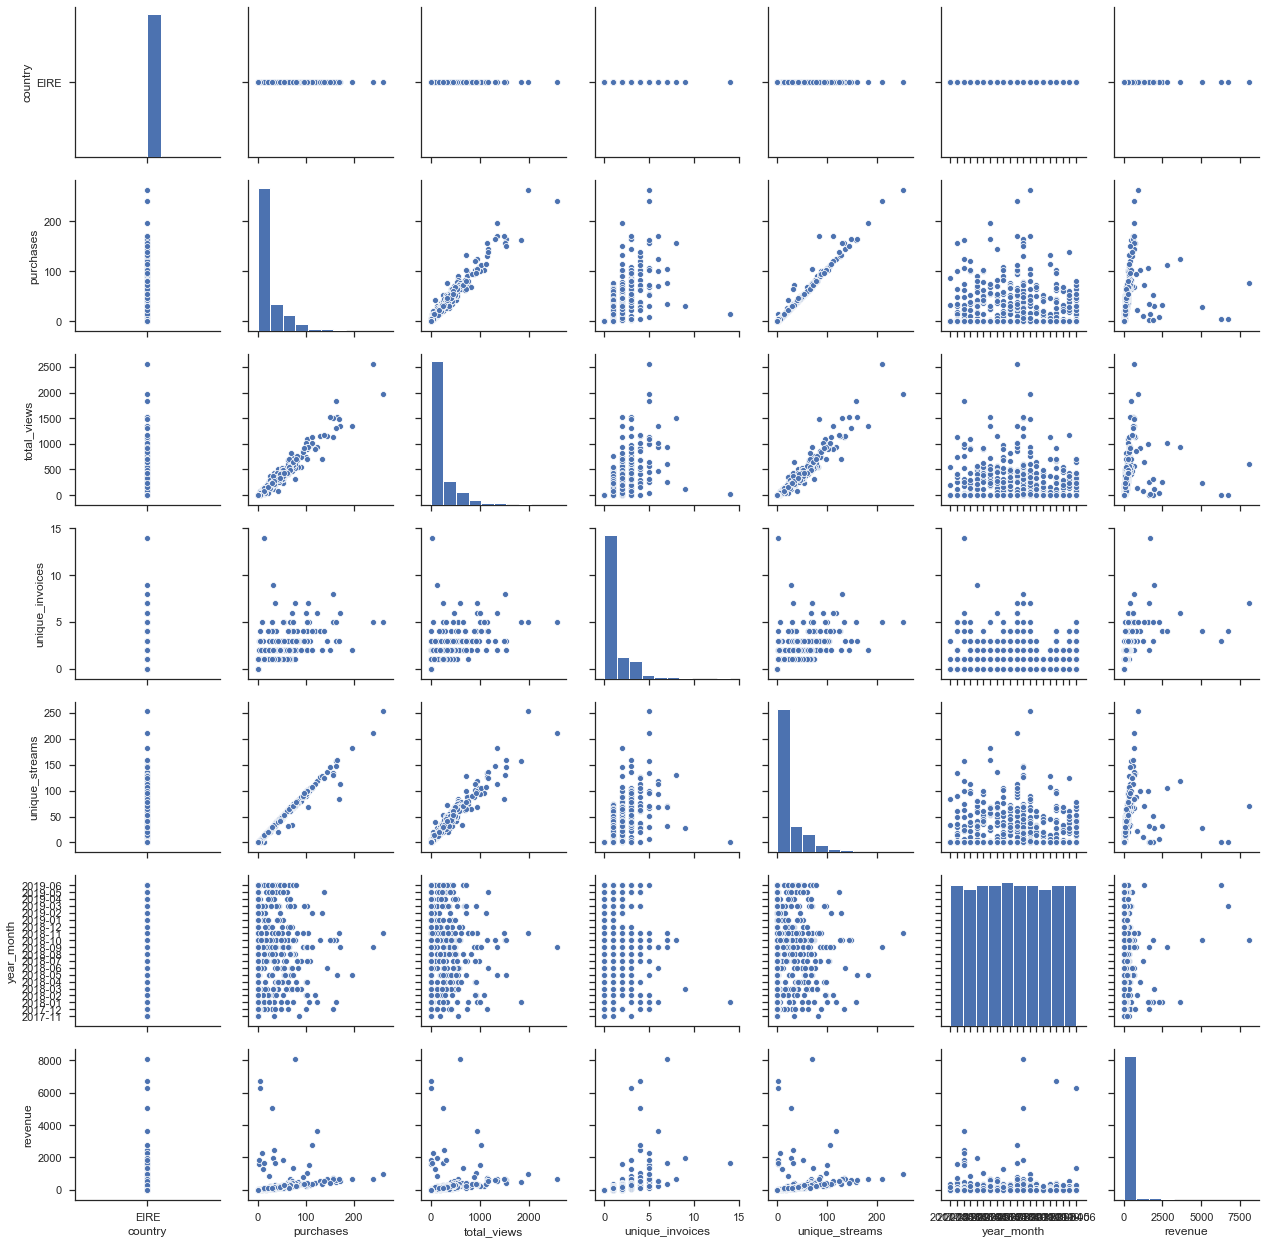

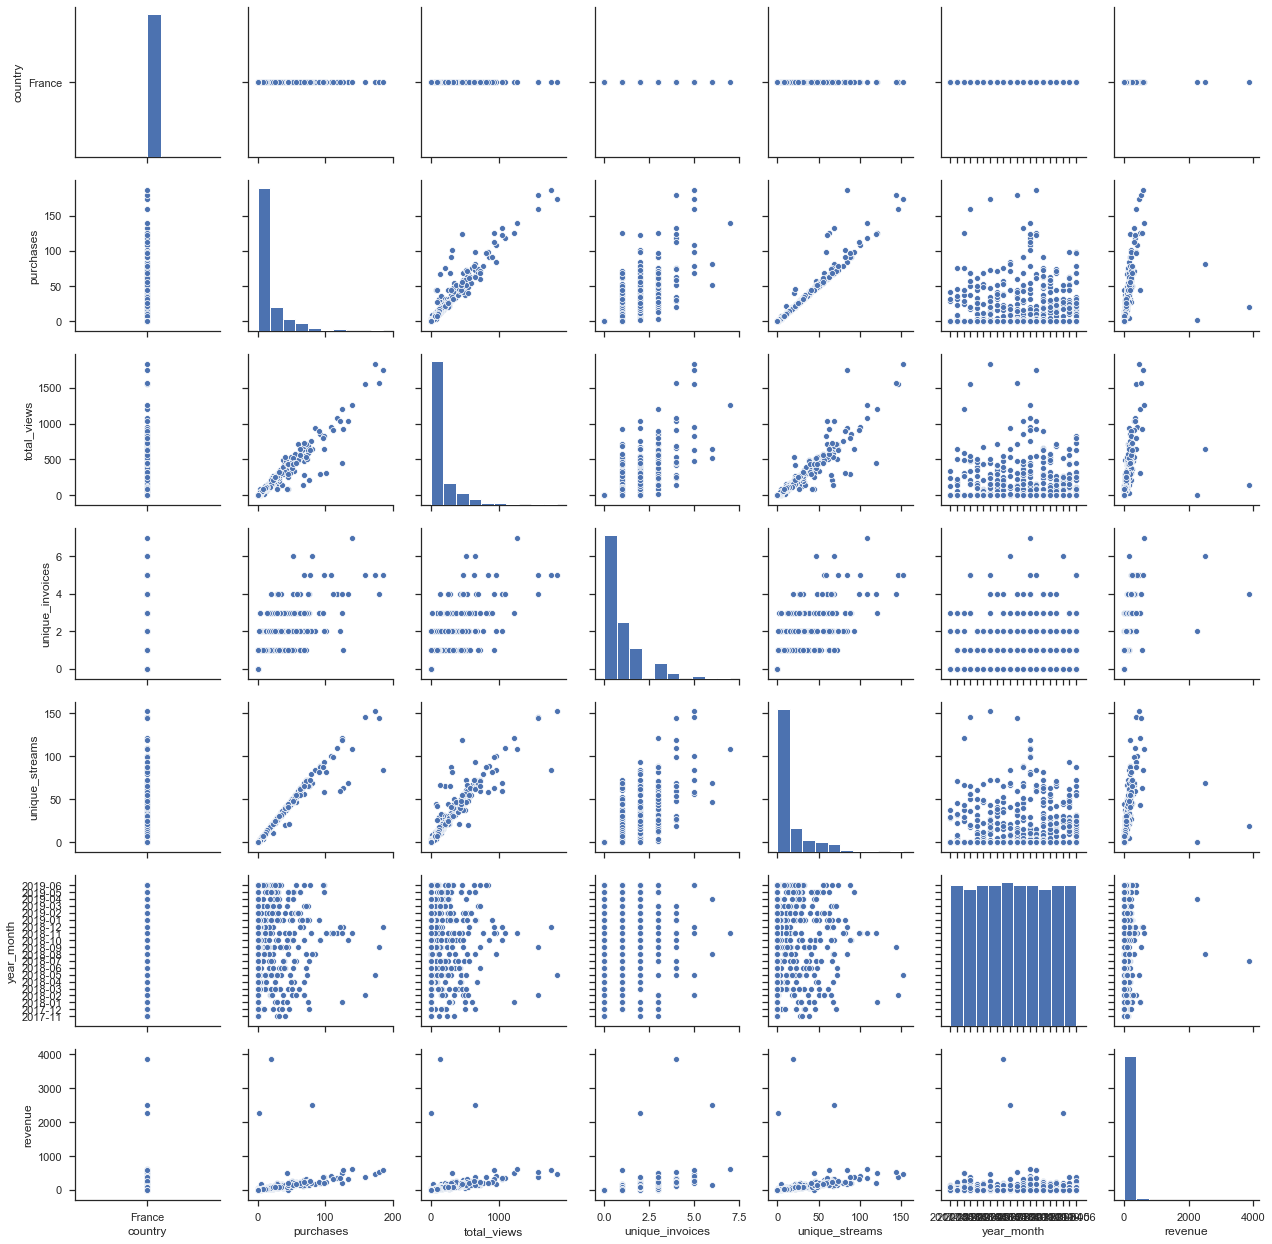

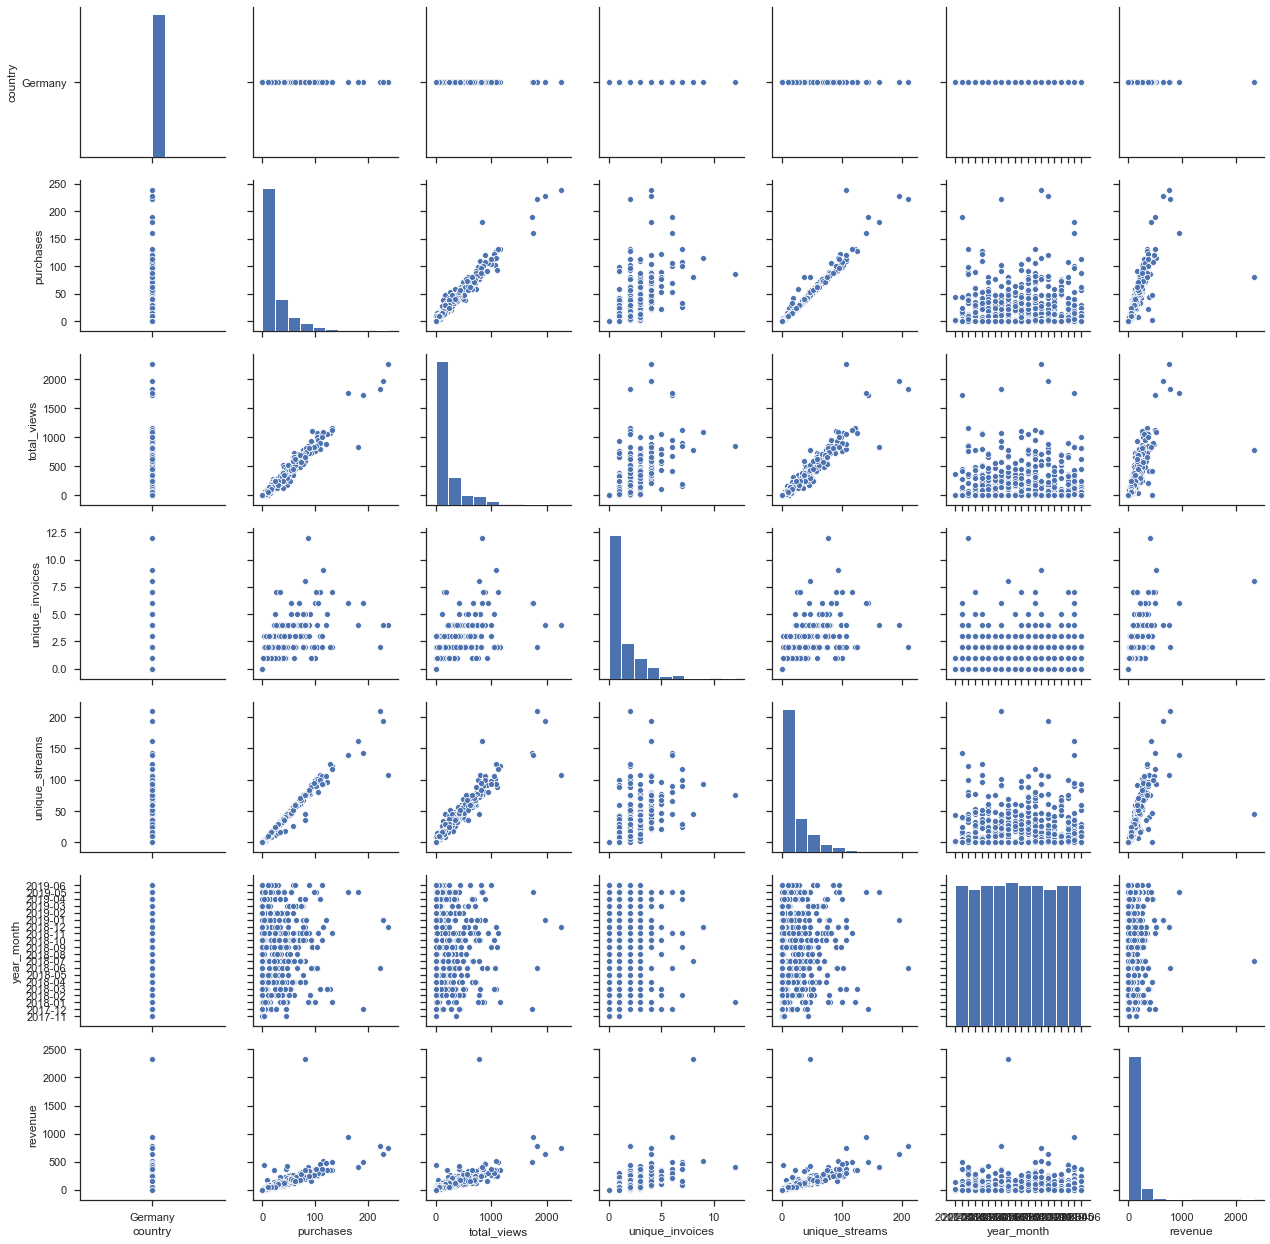

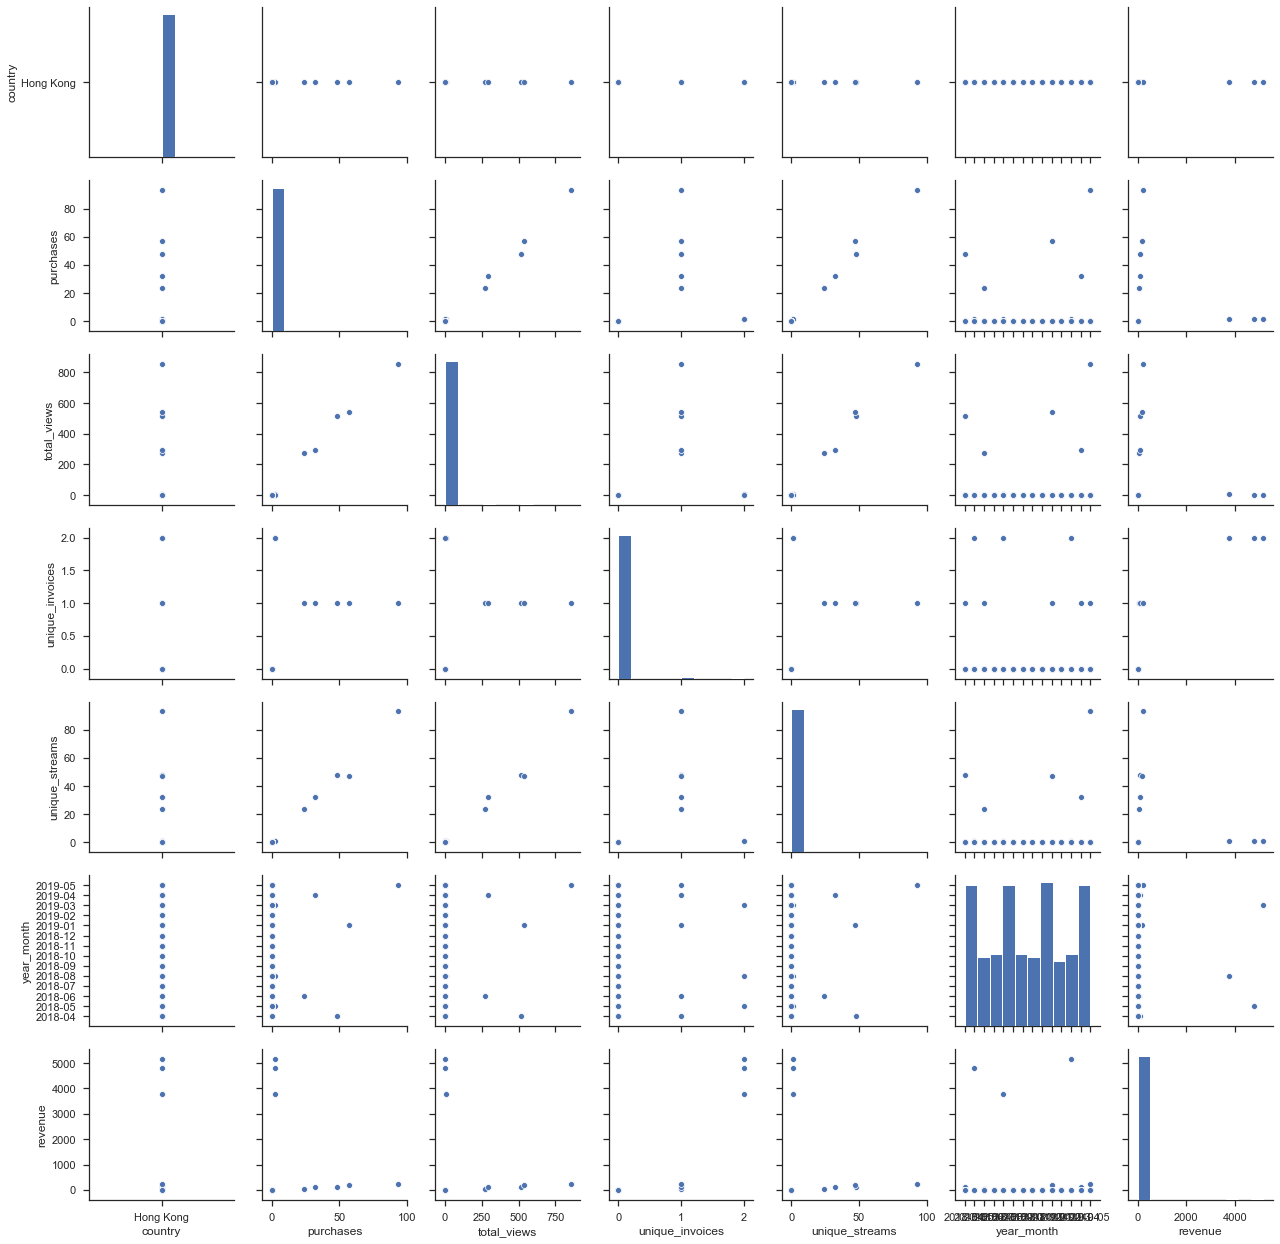

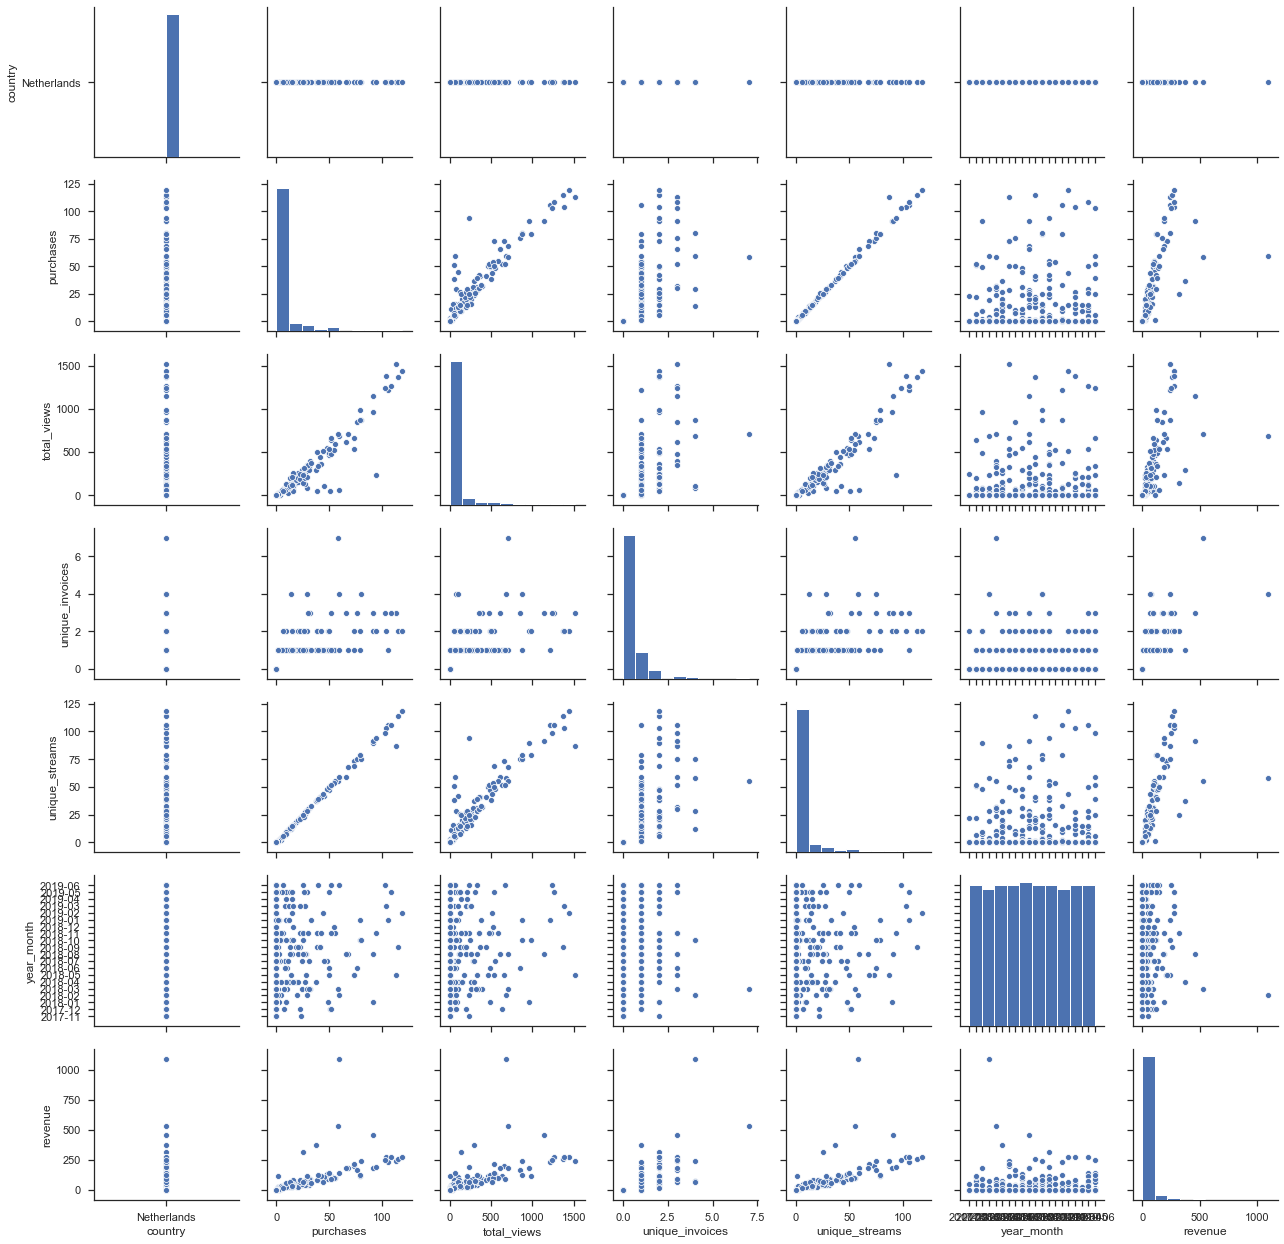

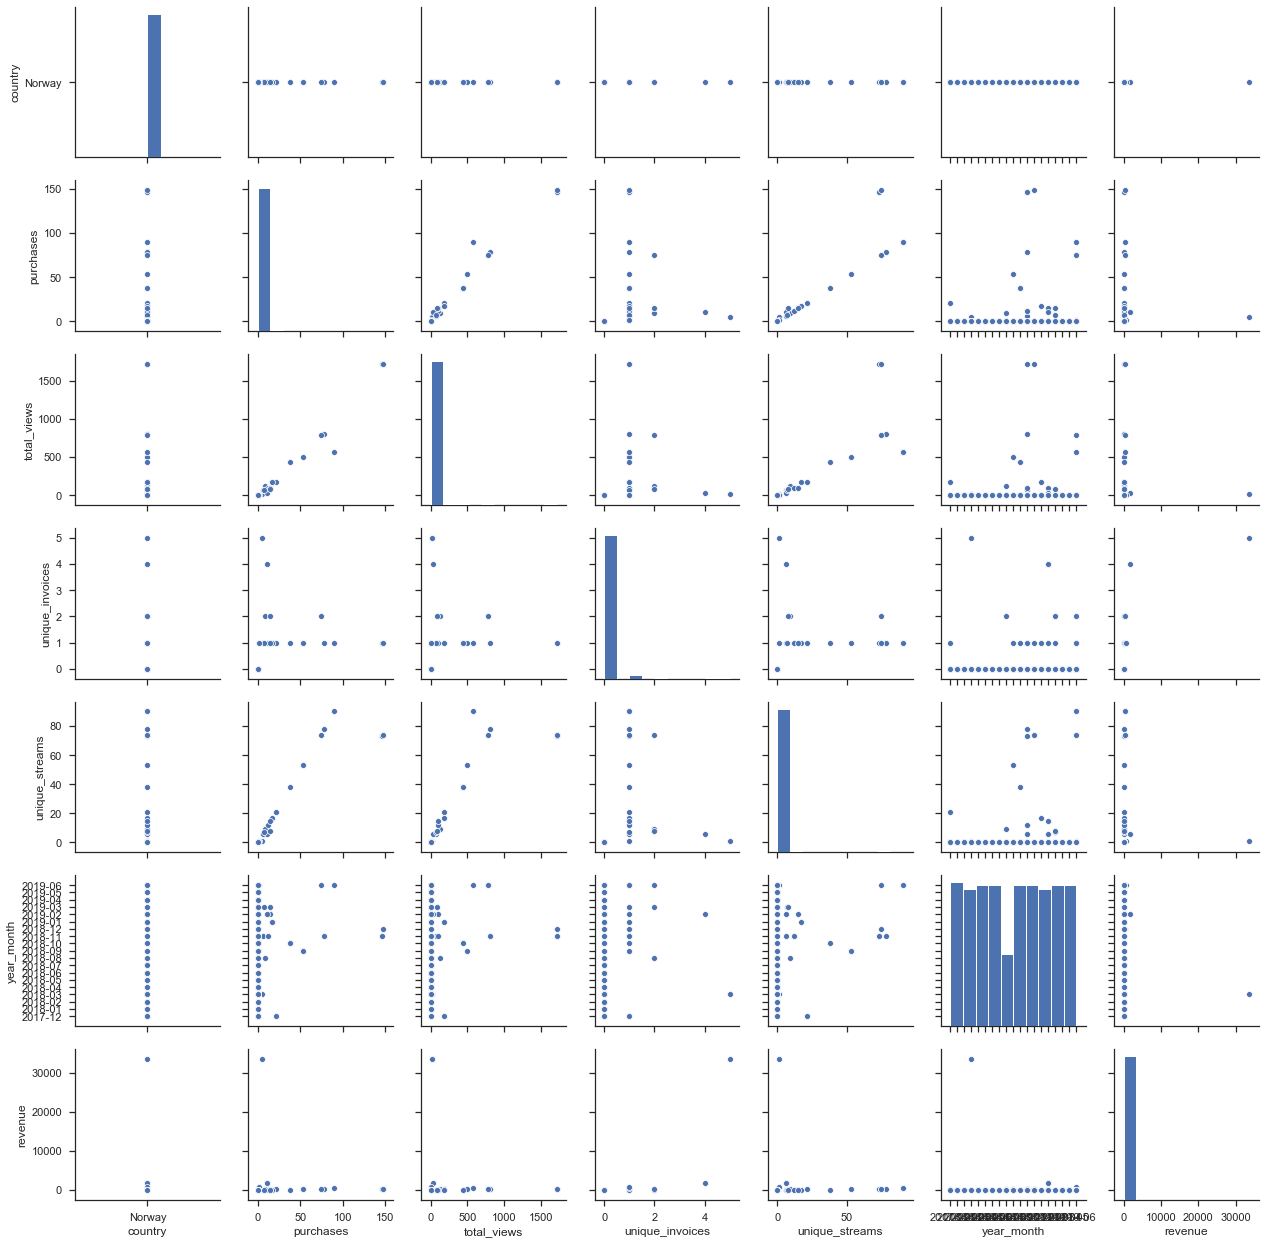

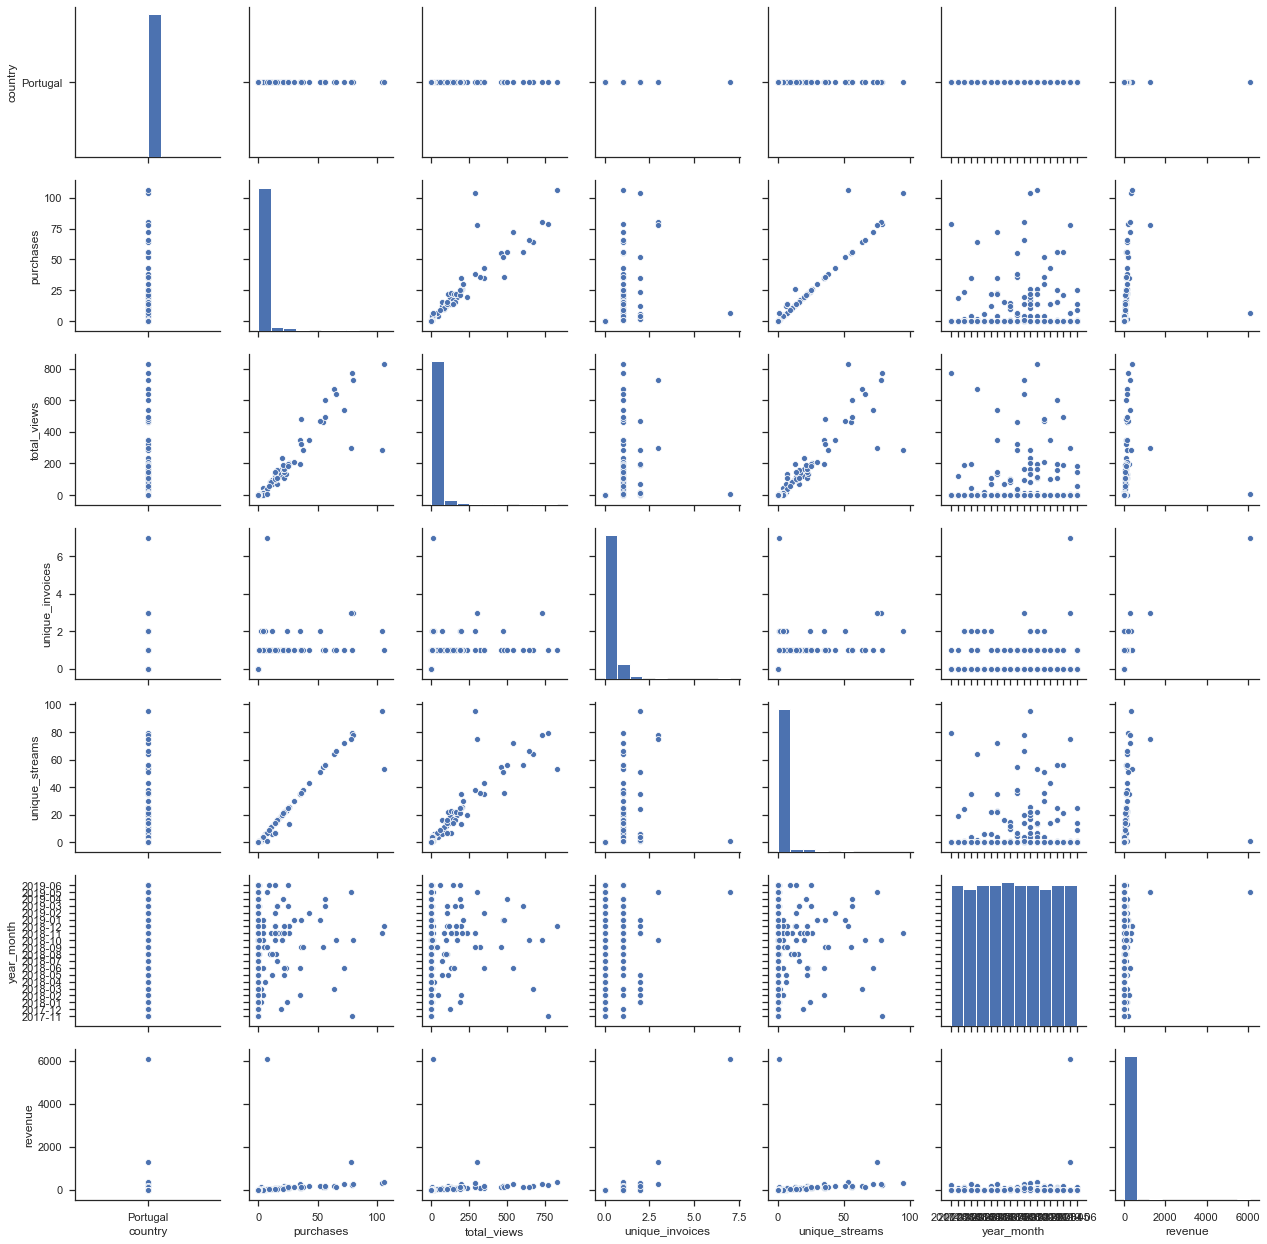

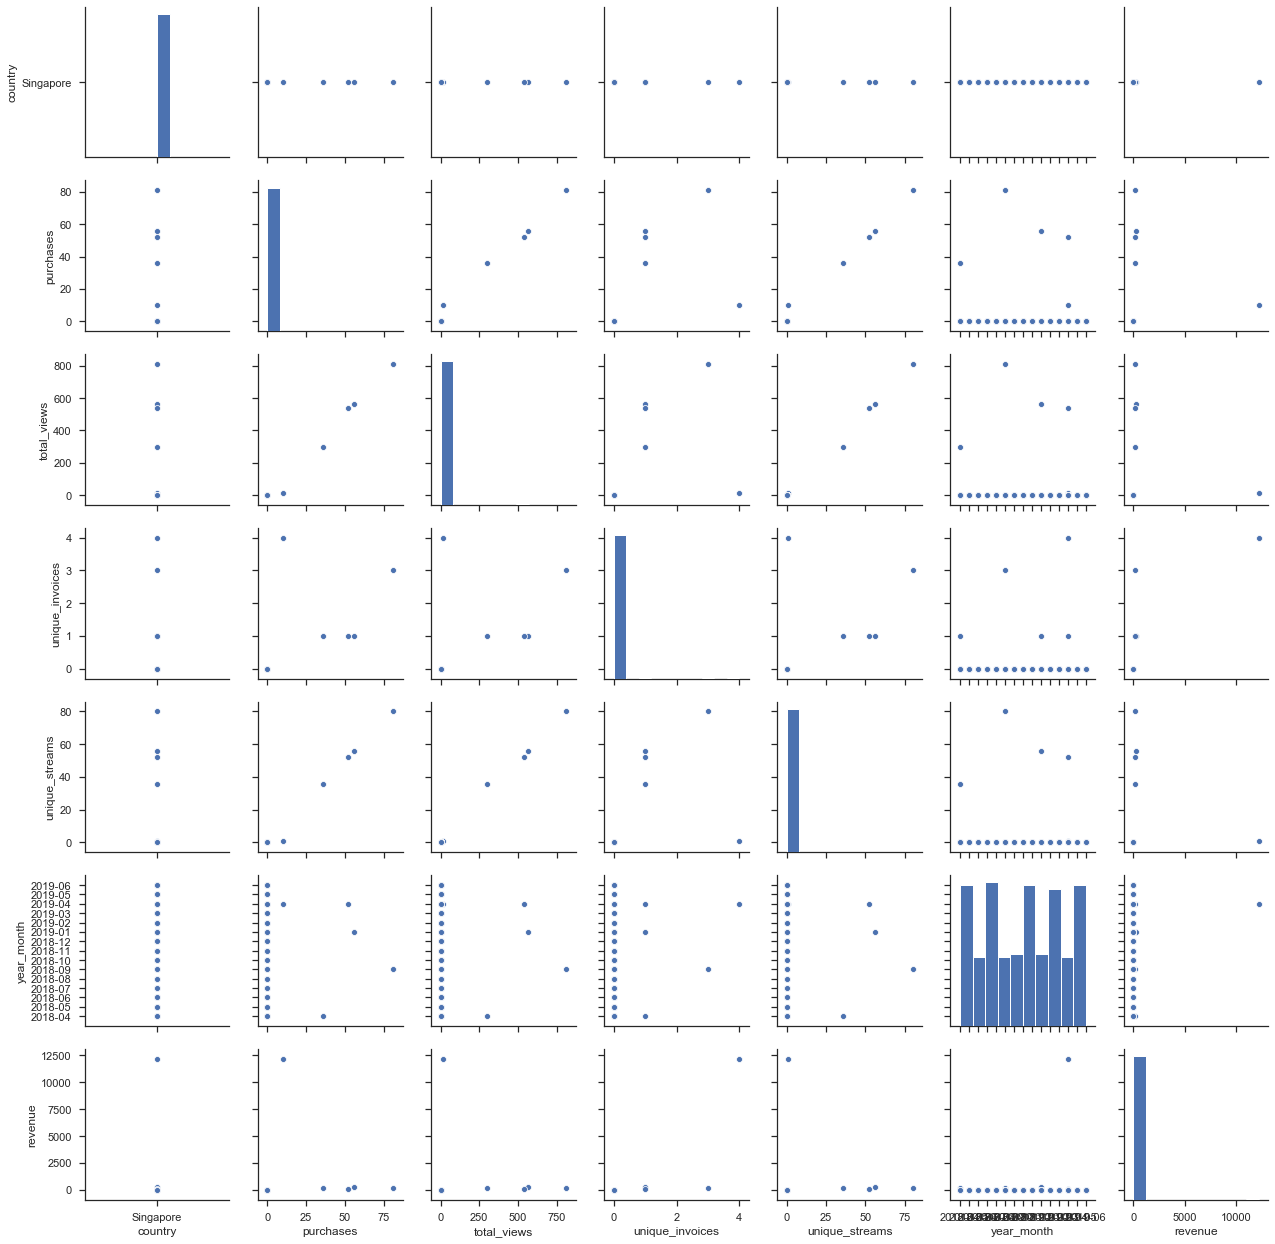

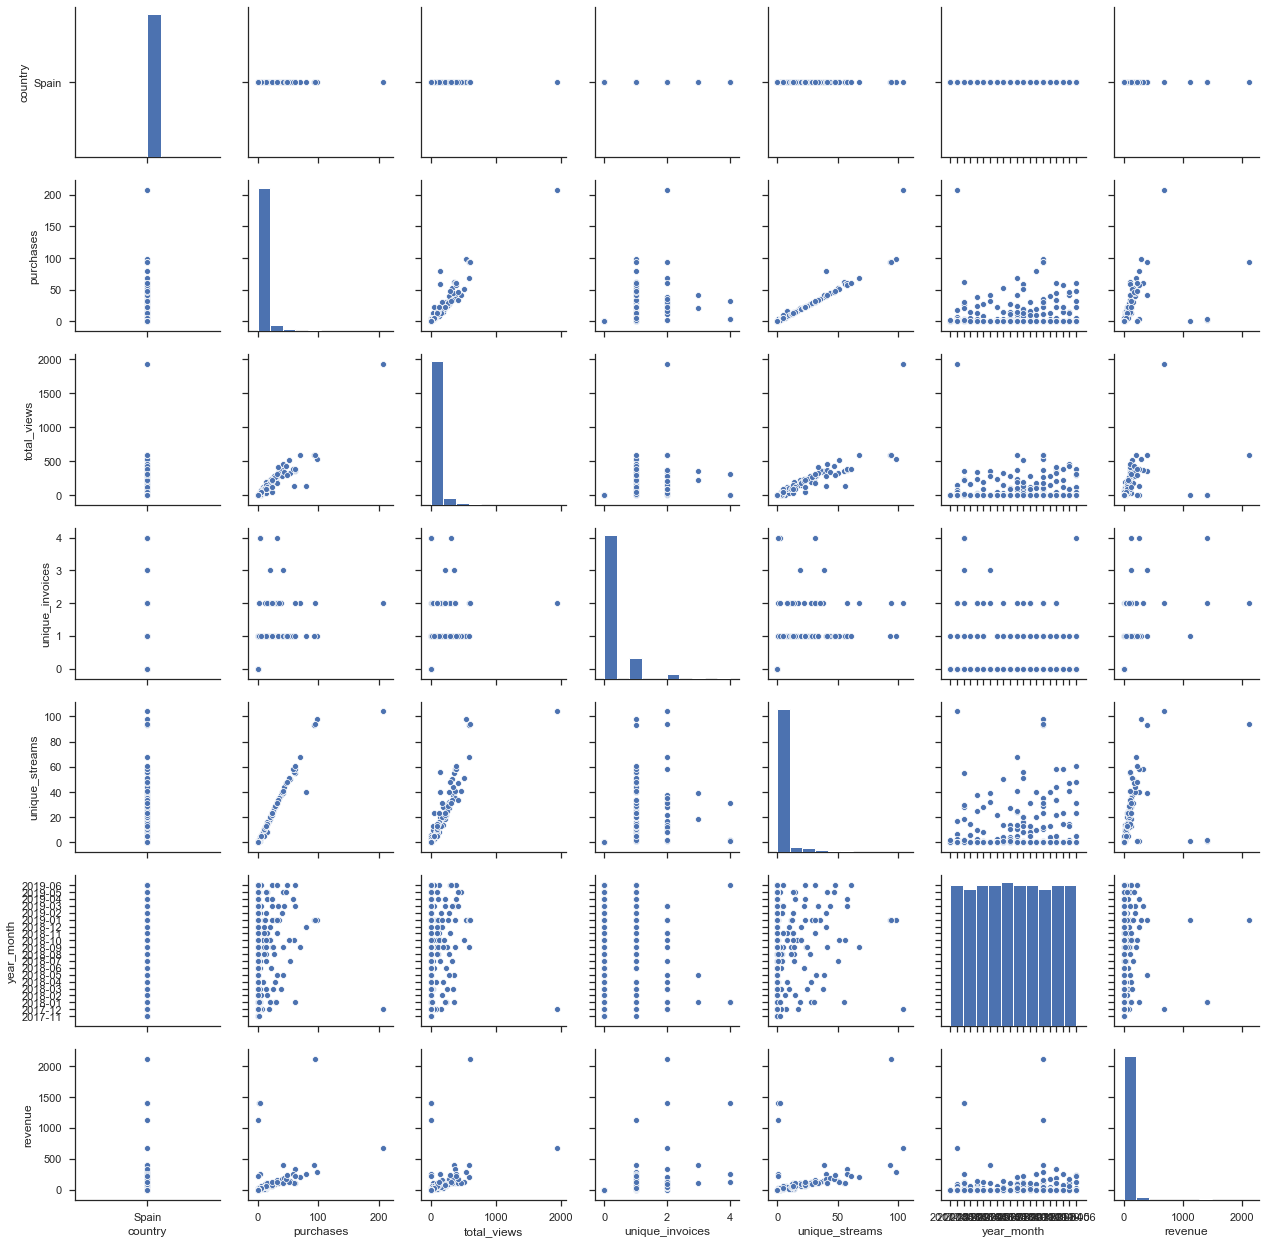

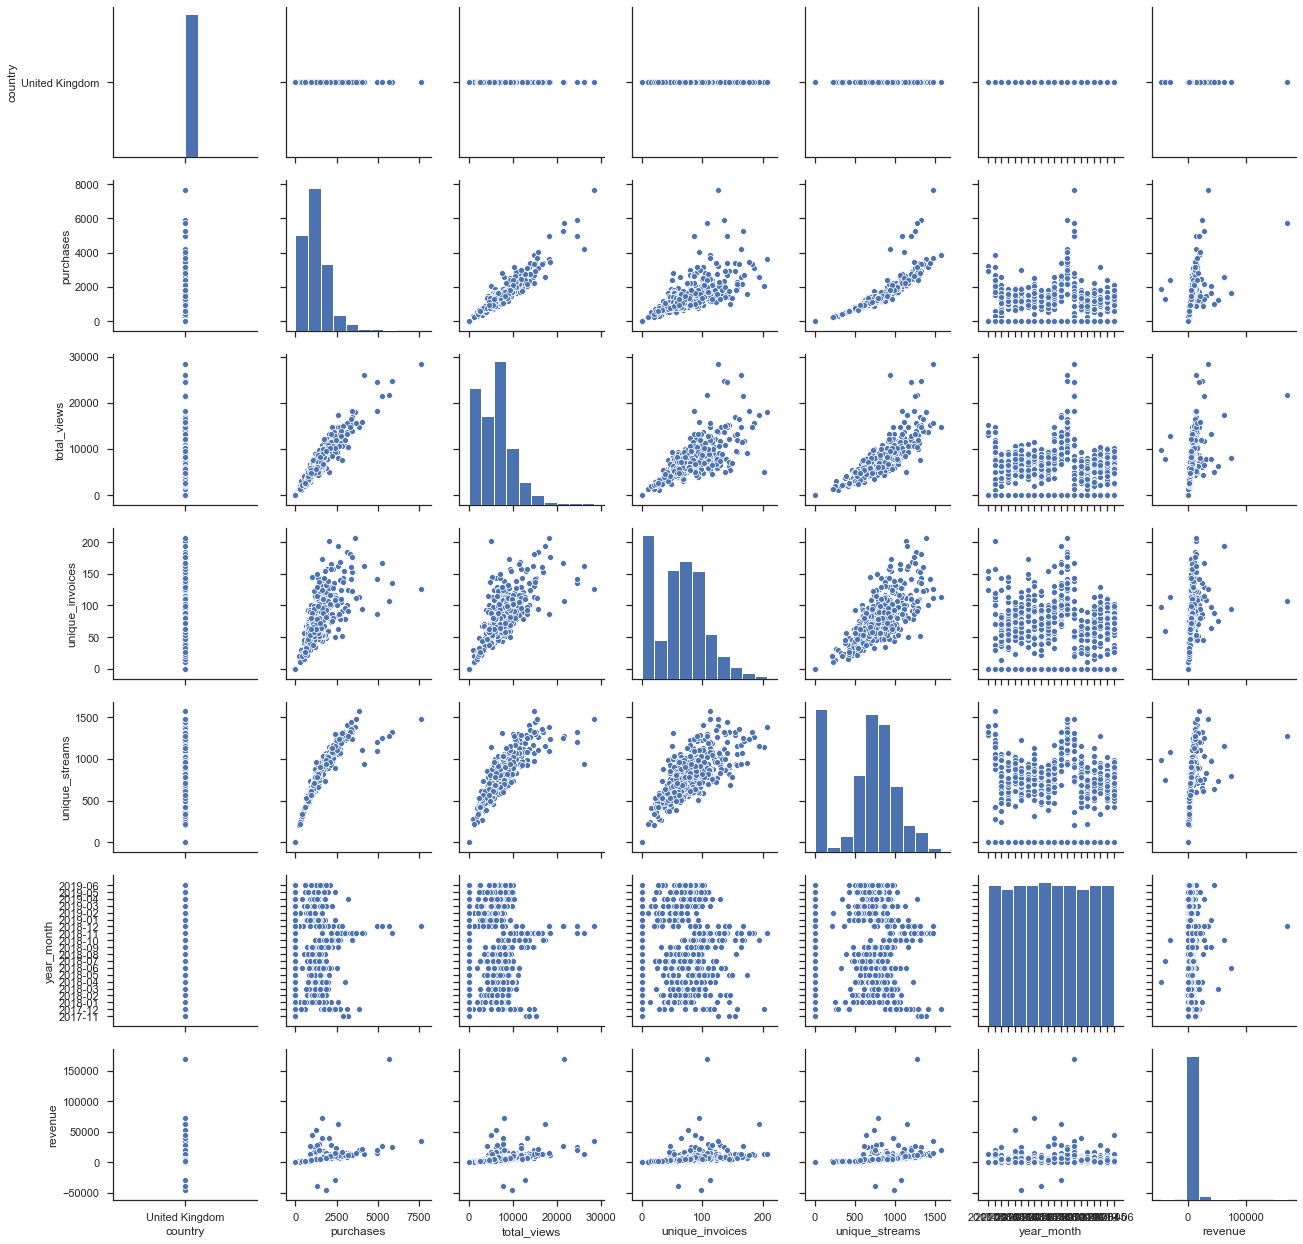

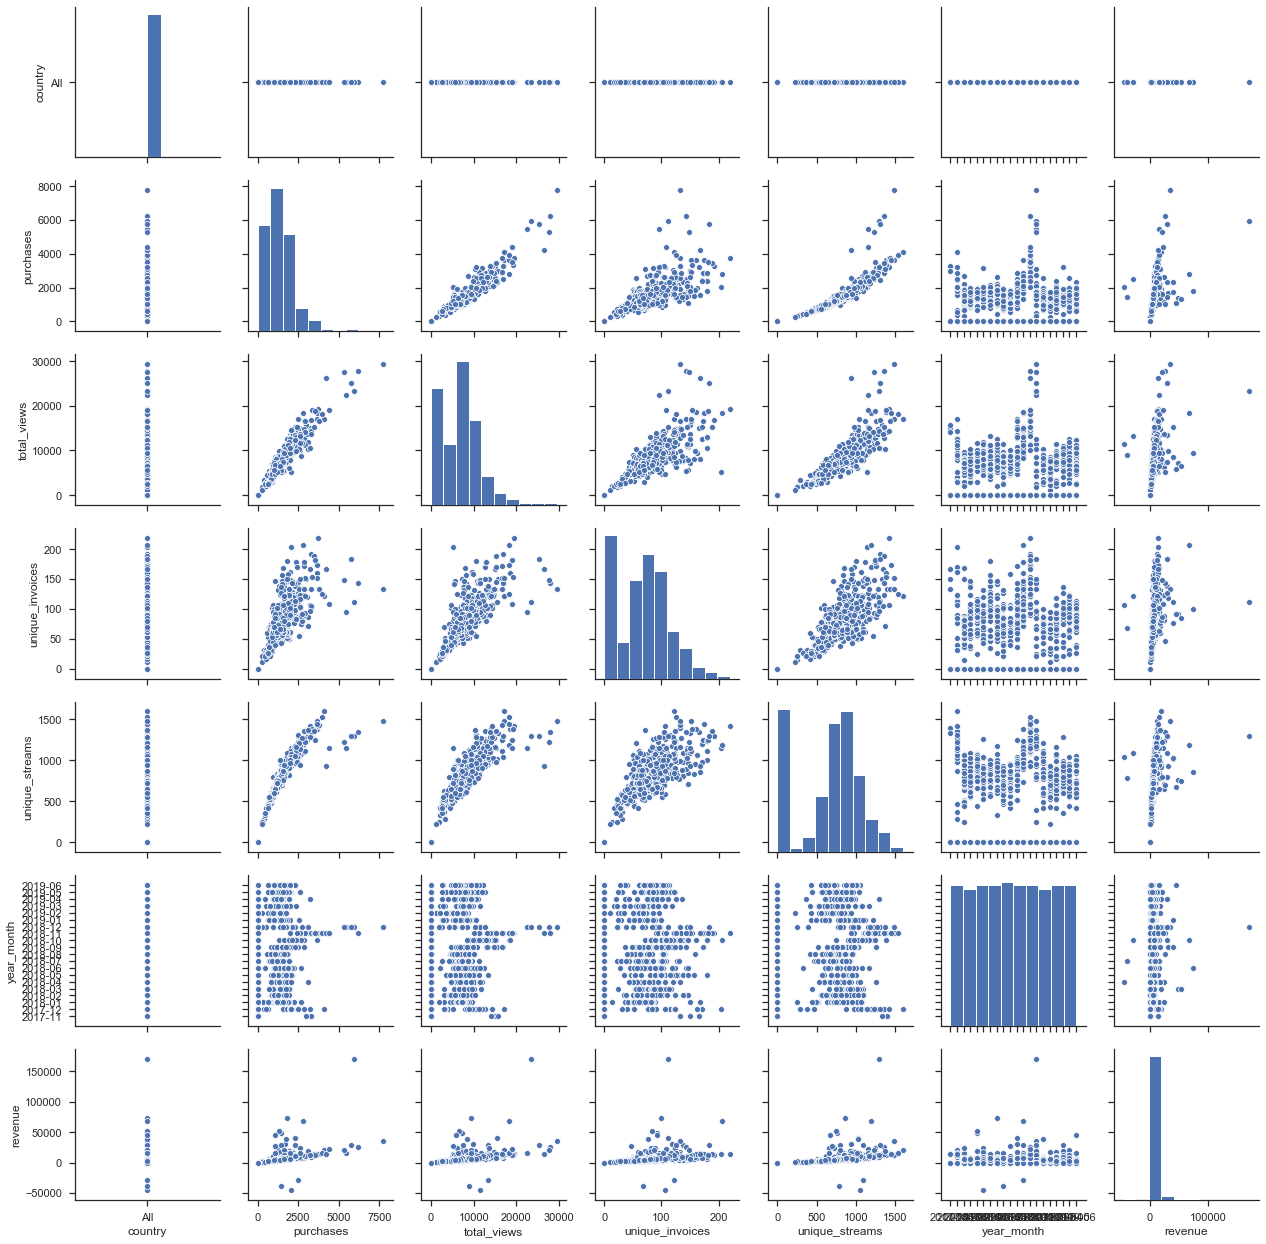

In [25]:
columns = ['country','purchases', 'total_views', 'unique_invoices',
               'unique_streams', 'year_month', 'revenue']

for i in range(1,12):
    country_name = country_list[i-1]    
    ## make a pair plot
    make_pairplot_by_country(df_ts_all,columns,country_name)

Pair plots for All:


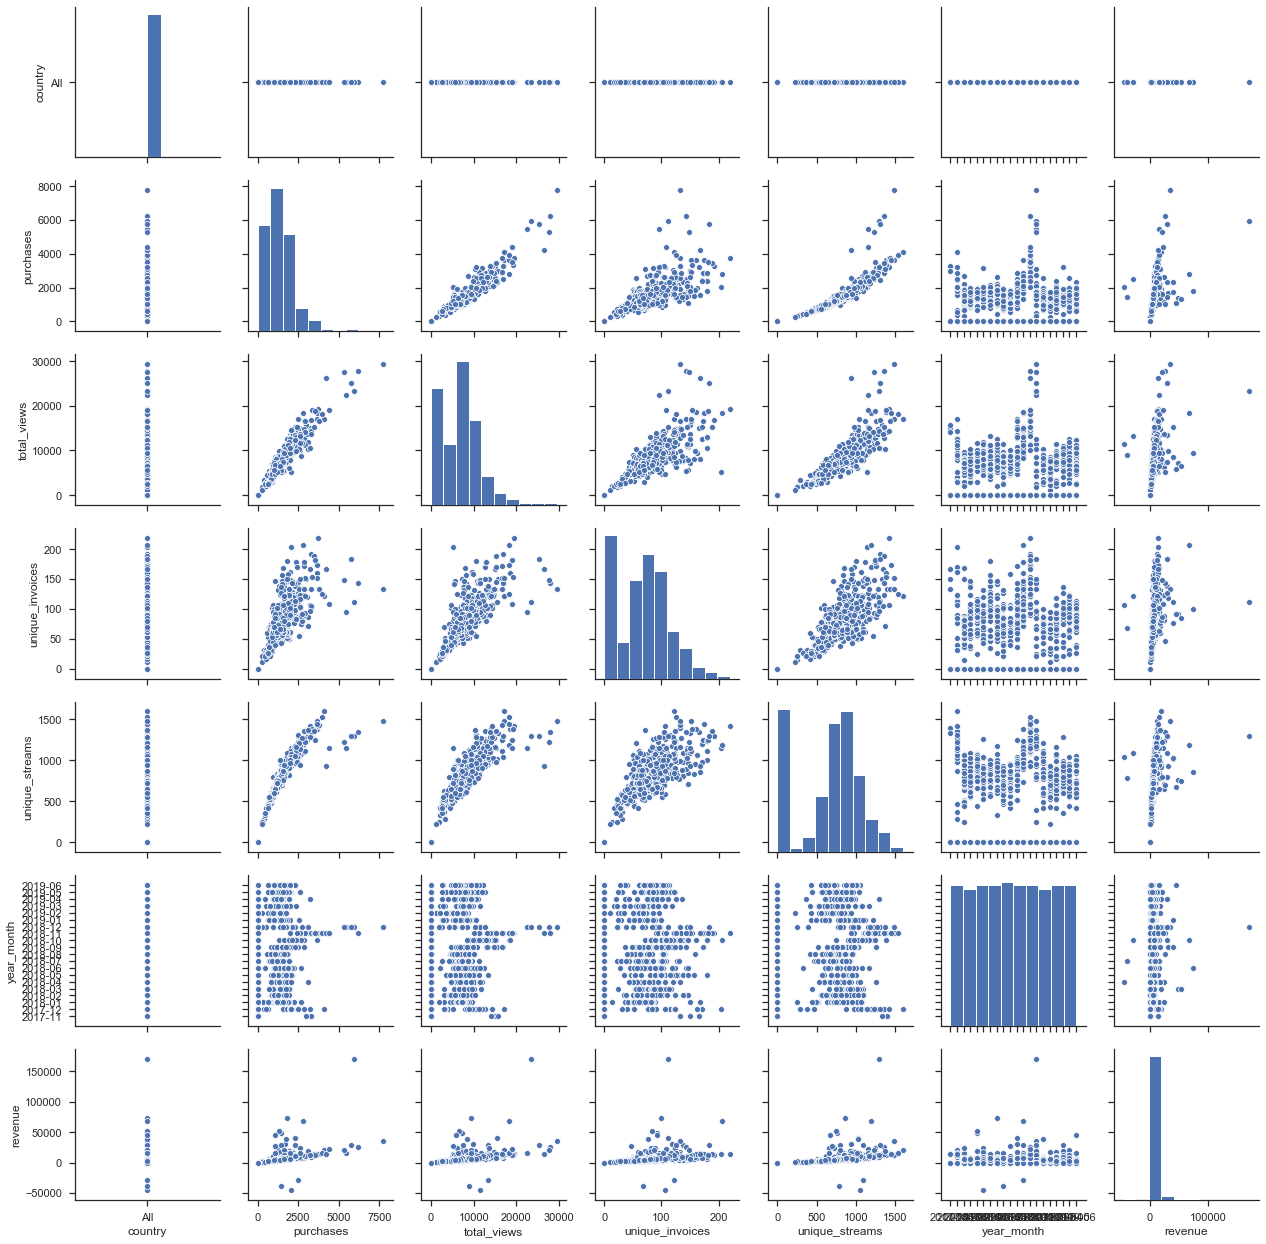

In [26]:
make_pairplot_by_country(df_ts_all,columns,country_name='All')

### 5.2 Correlation matrix

In [27]:
corr = df_ts_all[df_ts_all.country == 'All'].corr()
corr

purchases  unique_invoices  unique_streams  total_views  \
purchases         1.000000         0.820718        0.904122     0.963793   
unique_invoices   0.820718         1.000000        0.883725     0.873430   
unique_streams    0.904122         0.883725        1.000000     0.907363   
total_views       0.963793         0.873430        0.907363     1.000000   
revenue           0.534124         0.419227        0.433732     0.493350   
country_code           NaN              NaN             NaN          NaN   
yymm_code         0.120390         0.073368        0.121982     0.140171   

                  revenue  country_code  yymm_code  
purchases        0.534124           NaN   0.120390  
unique_invoices  0.419227           NaN   0.073368  
unique_streams   0.433732           NaN   0.121982  
total_views      0.493350           NaN   0.140171  
revenue          1.000000           NaN   0.070101  
country_code          NaN           NaN        NaN  
yymm_code        0.070101           NaN   1.000000

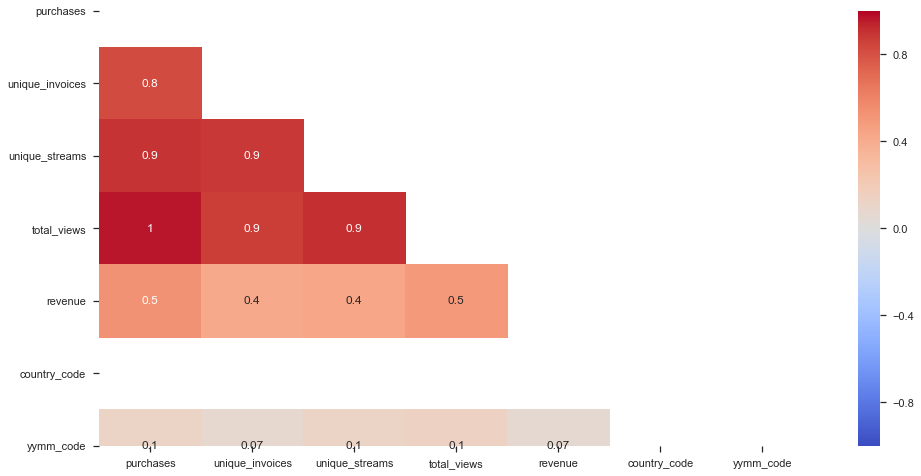

In [28]:
plt.figure(figsize=(16,8))

matrix = np.triu(df_ts_all[df_ts_all.country == 'All'].corr())

sns.heatmap(df_ts_all[df_ts_all.country == 'All'].corr(), annot= True, fmt='.1g',
           vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',
           mask=matrix)

### 5.3 Distribution of Total revenue by countries

In [29]:
top_10_countries = pd.pivot_table(df_ts_all[df_ts_all.country != 'All'], index= 'country',
               values='revenue',
               aggfunc='sum').round(0).sort_values(by='revenue', ascending=False).head(10)
top_10_countries = top_10_countries.reset_index(drop=False)
top_10_countries = top_10_countries.rename(columns={'country':'Country',
                                                    'revenue':'Revenue'})

Text(0, 0.5, 'Revenue')

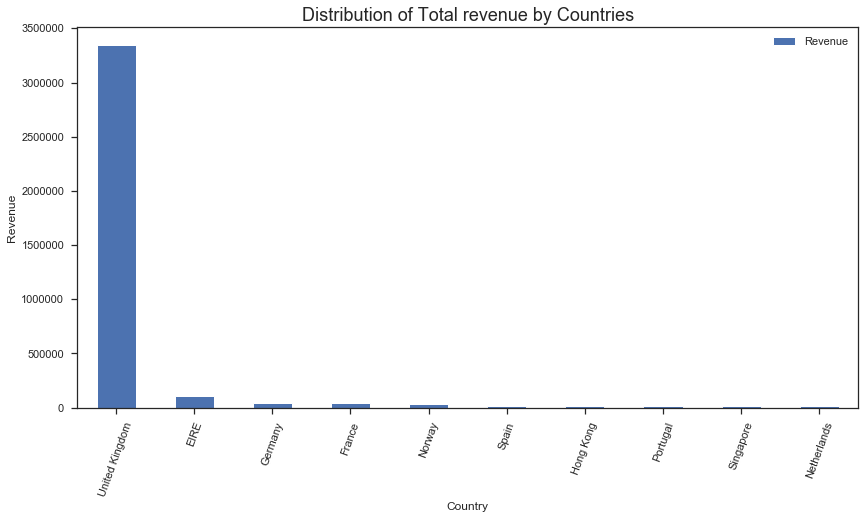

In [30]:
%matplotlib inline
ax = top_10_countries.plot.bar(x='Country', y='Revenue', 
                               rot=70, 
                               figsize=(14,7)).set_title("Distribution of Total revenue by Countries",
                                                         fontsize=18)

plt.ylabel('Revenue')

Insight: 
    The highest total revenue during the investigated period has United Kingdom.
    The difference between the UK's revenue and other countries revenue is the highest. 

### 5.4 Distribution of Total revenue over years

In [31]:
%matplotlib inline
df_yy_sum = pd.pivot_table(df_ts_all[df_ts_all.country == 'All'], index='year',
               values='revenue',
               aggfunc='sum').round(0).reset_index(drop=False).rename(columns={'revenue':'Revenue'})
df_yy_sum

year    Revenue
0  2017   198308.0
1  2018  2526013.0
2  2019   997620.0

Text(0, 0.5, 'Revenue')

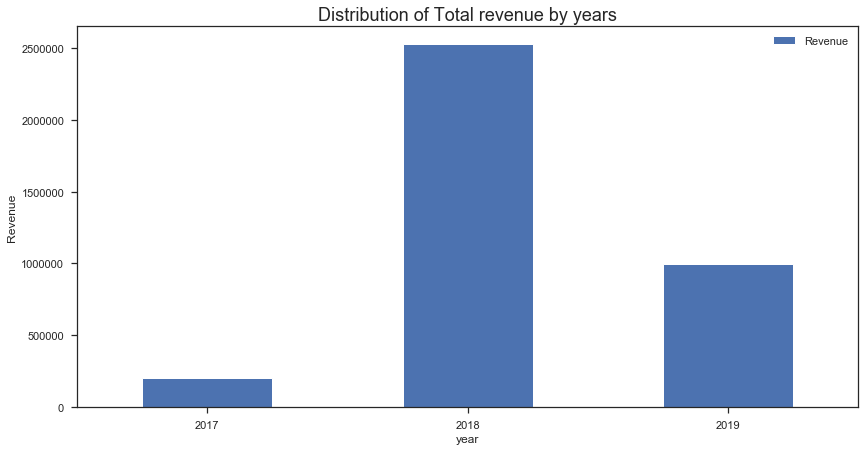

In [32]:
ax = df_yy_sum .plot.bar(x='year', y='Revenue',
                               rot=0, 
                               figsize=(14,7)).set_title("Distribution of Total revenue by years",
                                                         fontsize=18)

plt.ylabel('Revenue')

Insight: 
    The highest total revenue for TOP 10 countries was in 2018.

### 5.5 Distribution of Total revenue by countries over years

In [33]:
df_yy_all = pd.pivot_table(df_ts_all[df_ts_all.country != 'All'], index='country',columns='year',
               values='revenue',
               aggfunc='sum').round(0)
df_yy_all = df_yy_all.rename(columns={'revenue':'Revenue'})
df_yy_all

year                2017       2018      2019
country                                      
EIRE              4433.0    74398.0   25758.0
France            1200.0    24538.0   13247.0
Germany           1526.0    30554.0   13571.0
Hong Kong            NaN     8715.0    5678.0
Netherlands        384.0     8948.0    2964.0
Norway             123.0    34716.0    3486.0
Portugal           294.0     4292.0    8741.0
Singapore            NaN      373.0   12573.0
Spain              845.0     7312.0    7237.0
United Kingdom  187241.0  2272136.0  884175.0

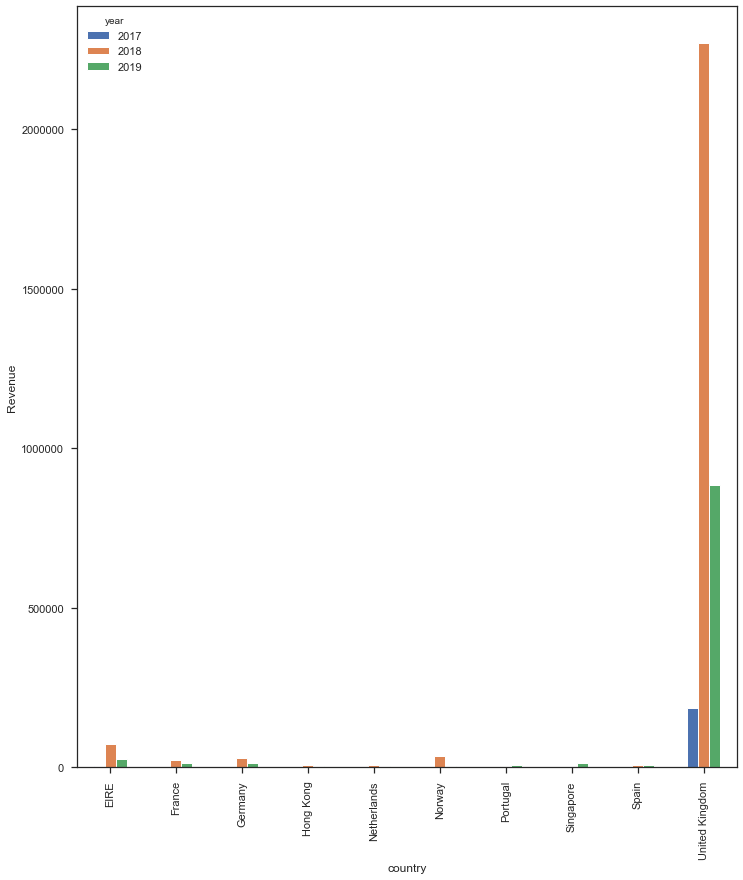

In [34]:
fig = plt.figure(figsize=(26,14))
ax1 = fig.add_subplot(121)

df_yy_all.plot(kind='bar',ax=ax1)
ax1.set_ylabel("Revenue");

#### Insight:
    Total revenue by countries over years shows that United Kingdom has the the highest revenue also over years. 
    The highest revenue was in 2018.
    2018 was the strongest year from the revenues point of view also for EIRE, Norway, Germany and France.

### 5.6 Total revenue by year and month for all TOP 10 countries

In [35]:
df_yymm_all = pd.pivot_table(df_ts_all[df_ts_all.country == 'All'], index= ['year_month_sh'],
               values='revenue',
               aggfunc='sum').round(0).sort_values(by=['year_month_sh','revenue'], 
                                                   ascending=[True, False]).reset_index(drop=False)
df_yymm_all = df_yymm_all.rename(columns={'revenue':'Revenue'})
df_yymm_all

year_month_sh   Revenue
0          17-11   41153.0
1          17-12  157155.0
2          18-01  183680.0
3          18-02  116345.0
4          18-03  257428.0
5          18-04  116642.0
6          18-05  155749.0
7          18-06  229099.0
8          18-07  108379.0
9          18-08  156605.0
10         18-09  222501.0
11         18-10  279361.0
12         18-11  335171.0
13         18-12  365052.0
14         19-01  188111.0
15         19-02  128477.0
16         19-03  161573.0
17         19-04  152566.0
18         19-05  176966.0
19         19-06  189927.0

No handles with labels found to put in legend.


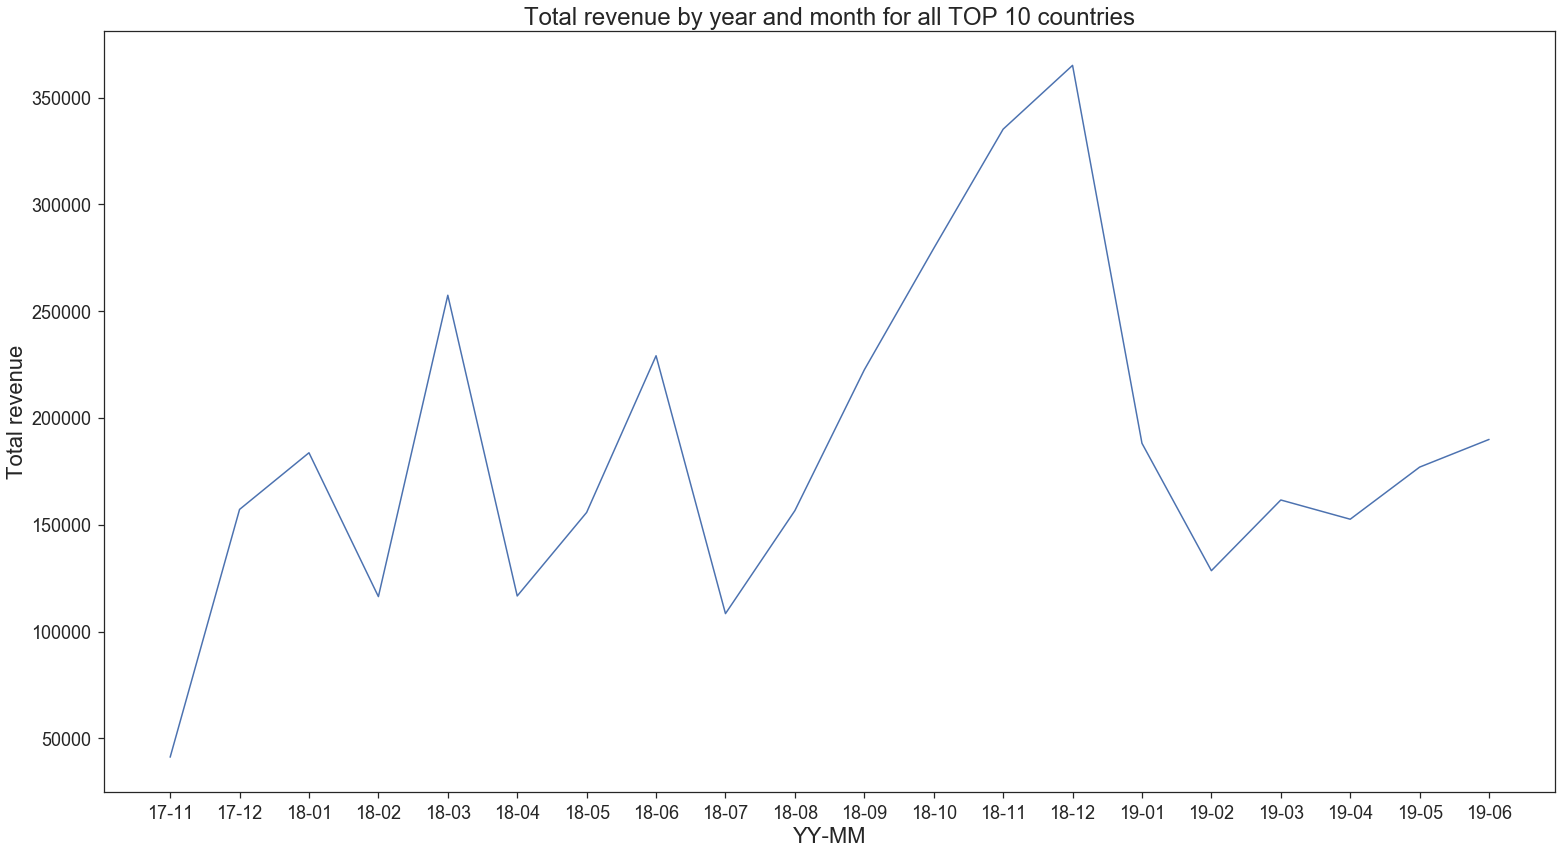

In [36]:
plt.figure(figsize=(26,14))

ax1 = sns.lineplot(x='year_month_sh', y='Revenue',             
             data=df_yymm_all).set_title("Total revenue by year and month for all TOP 10 countries",
                                         fontsize=24)
        
plt.xticks(df_yymm_all.year_month_sh, fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('YY-MM',fontsize=22)
plt.ylabel('Total revenue',fontsize=22)
plt.legend(loc='upper right',fontsize=18)

#### Insight:
    Up and down trend can be seen with multiple peaks and with the highest peak in Dec 2018.
    From April 2019 increasing trend is typical.
    November and December indicate a trend for the highest level of activity - some seasonal trend can be seen.
    It could be possible that each year there is a free trial period or some sort of promotion that attracts viewers. 

### 5.7 Total revenue by year and month for TOP 10 countries

In [37]:
df_yymm = pd.pivot_table(df_ts_all[df_ts_all.country != 'All'], index= ['year_month_sh','country'],
               values='revenue',
               aggfunc='sum').round(0).sort_values(by=['year_month_sh','revenue'], 
                                                   ascending=[True, False]).reset_index(drop=False)
df_yymm = df_yymm.rename(columns={'country':'Country', 'revenue':'Revenue'})
df_yymm

year_month_sh         Country  Revenue
0           17-11  United Kingdom  39446.0
1           17-11            EIRE    570.0
2           17-11          France    352.0
3           17-11        Portugal    209.0
4           17-11         Germany    156.0
..            ...             ...      ...
183         19-06          Norway   1521.0
184         19-06           Spain    739.0
185         19-06     Netherlands    691.0
186         19-06        Portugal    171.0
187         19-06       Singapore      0.0

[188 rows x 3 columns]

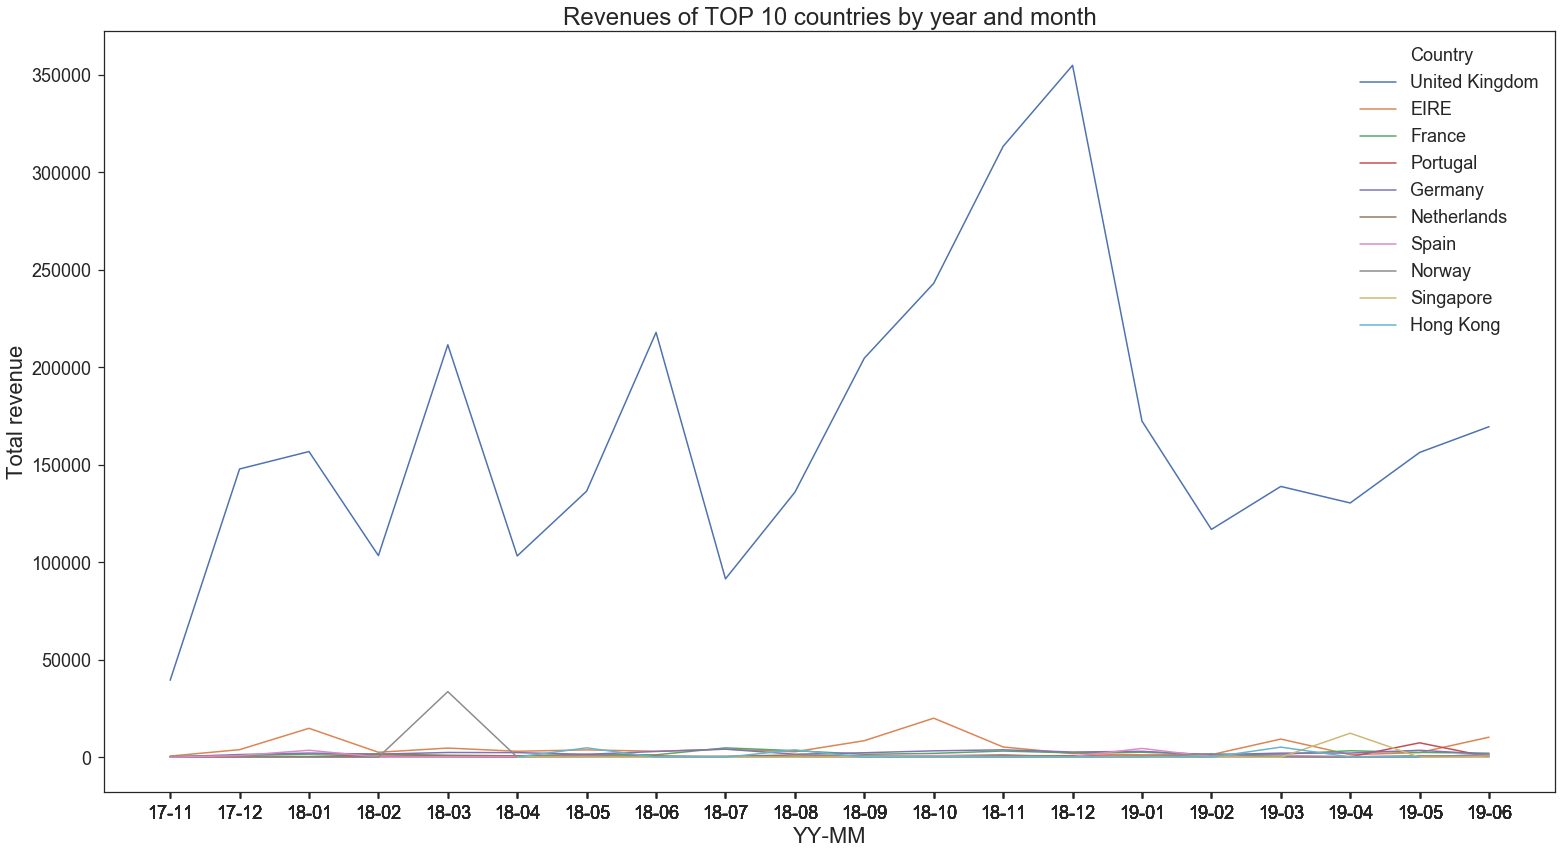

In [38]:
plt.figure(figsize=(26,14))

ax1 = sns.lineplot(x='year_month_sh', y='Revenue', hue='Country',             
             data=df_yymm).set_title("Revenues of TOP 10 countries by year and month",fontsize=24)
        
plt.xticks(df_yymm.year_month_sh, fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('YY-MM',fontsize=22)
plt.ylabel('Total revenue',fontsize=22)
plt.legend(loc='upper right',fontsize=18)

#### Insight:
    The monthly distribution shows that UK has the significantly highest revenue over the time.
    The trend is volatile with highest peak in Dec 2018 and with incrasing trend for last 3 months.
    
    The up and down trend can be seen for EIRE, Norway and Singapore
    
    The highest total revenue during the investigated period has United Kingdom.
    The difference between the UK's revenue and other countries revenue is very large. 

### 5.8 Total revenue by year and month for each TOP 10 countries

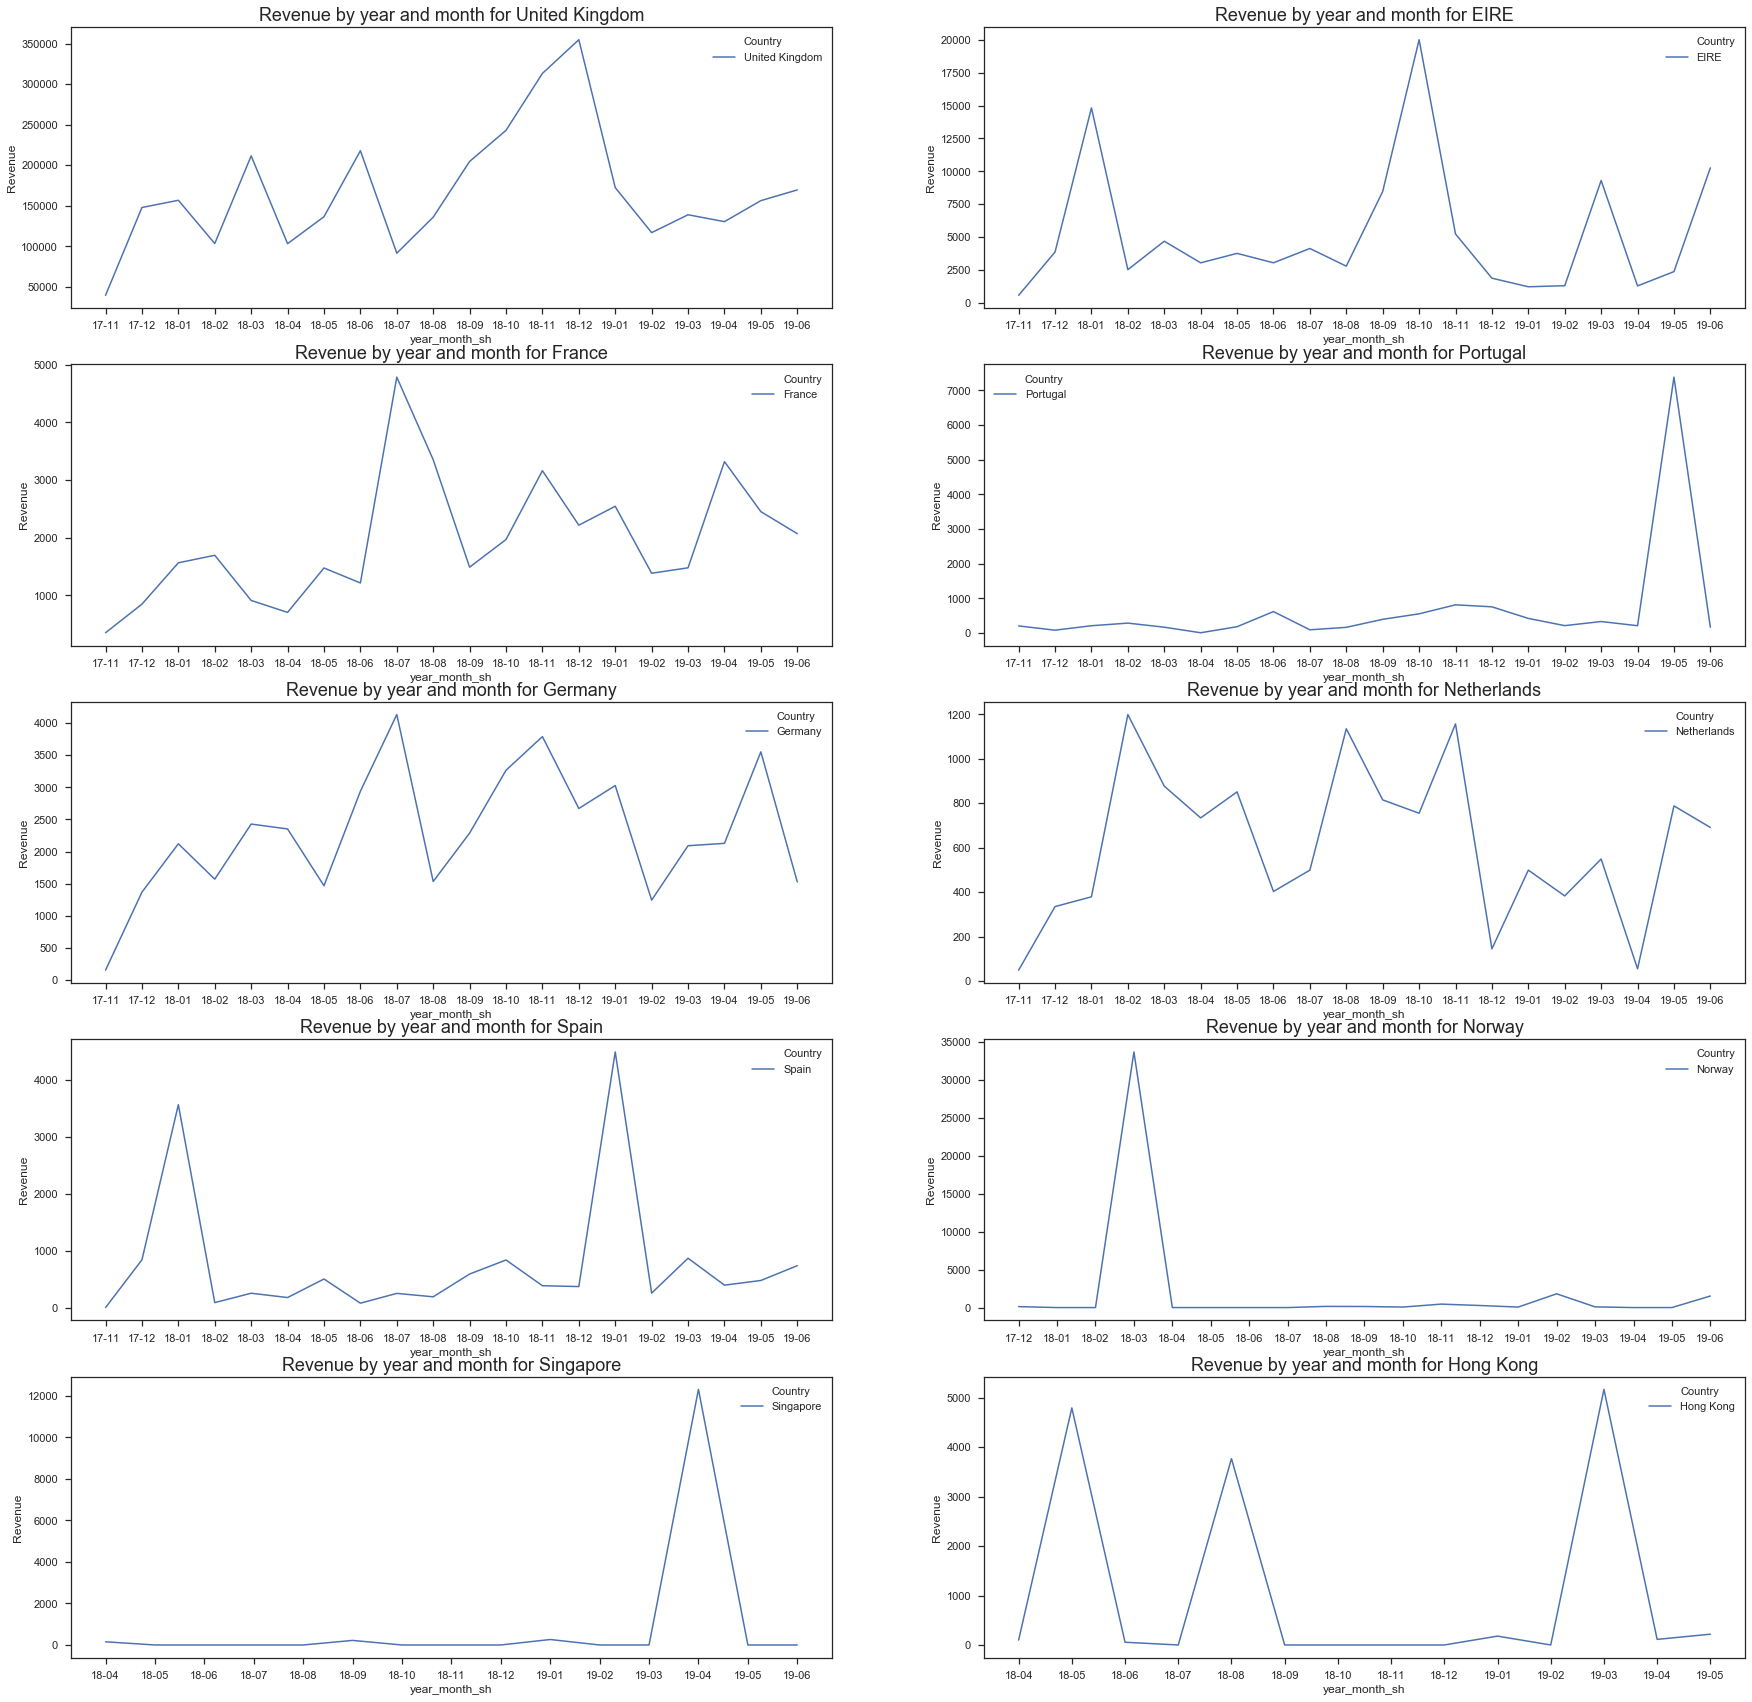

In [39]:
fig = plt.figure(figsize=(30,30))

country_list = df_yymm.Country.unique()

for i in range(1,11):
    ax = fig.add_subplot(5, 2, i)
    country_name = country_list[i-1]
    
    sns.lineplot(x='year_month_sh', y='Revenue', hue='Country',             
             data=df_yymm[df_yymm.Country == country_name]).set_title("Revenue by year and month for "+country_name,
                                                                     fontsize=18)

#### Insight:
    Revenue trend is different for each country. 
    Volatile trend with high peaks are typical for: United Kingdom, France, Germany, Netherlands and EIRE.
    Most of the time flat trend can be seen for: Portugal, Norway and Singapore.
    In Spain the trend tend to be increasing with two high peaks in January 2018 and 2019.
    Clear up and down trend is seen for Hong Kong.

    The data time range is different for Norway, Singapore and Hong Kong. It seems these countries started later.

### 5.9 Total views by year and month for TOP 10 countries

In [40]:
df_yymm_tv = pd.pivot_table(df_ts_all[df_ts_all.country != 'All'], index= ['year_month_sh','country'],
               values='total_views',
               aggfunc='sum').round(0).sort_values(by=['year_month_sh','total_views'], 
                                                   ascending=[True, False]).reset_index(drop=False)
df_yymm_tv = df_yymm_tv.rename(columns={'country':'Country', 'total_views':'Total views'})
df_yymm_tv

year_month_sh         Country  Total views
0           17-11  United Kingdom      41815.0
1           17-11        Portugal        771.0
2           17-11            EIRE        737.0
3           17-11          France        704.0
4           17-11         Germany        374.0
..            ...             ...          ...
183         19-06     Netherlands       2586.0
184         19-06          Norway       1356.0
185         19-06           Spain       1170.0
186         19-06        Portugal        391.0
187         19-06       Singapore          0.0

[188 rows x 3 columns]

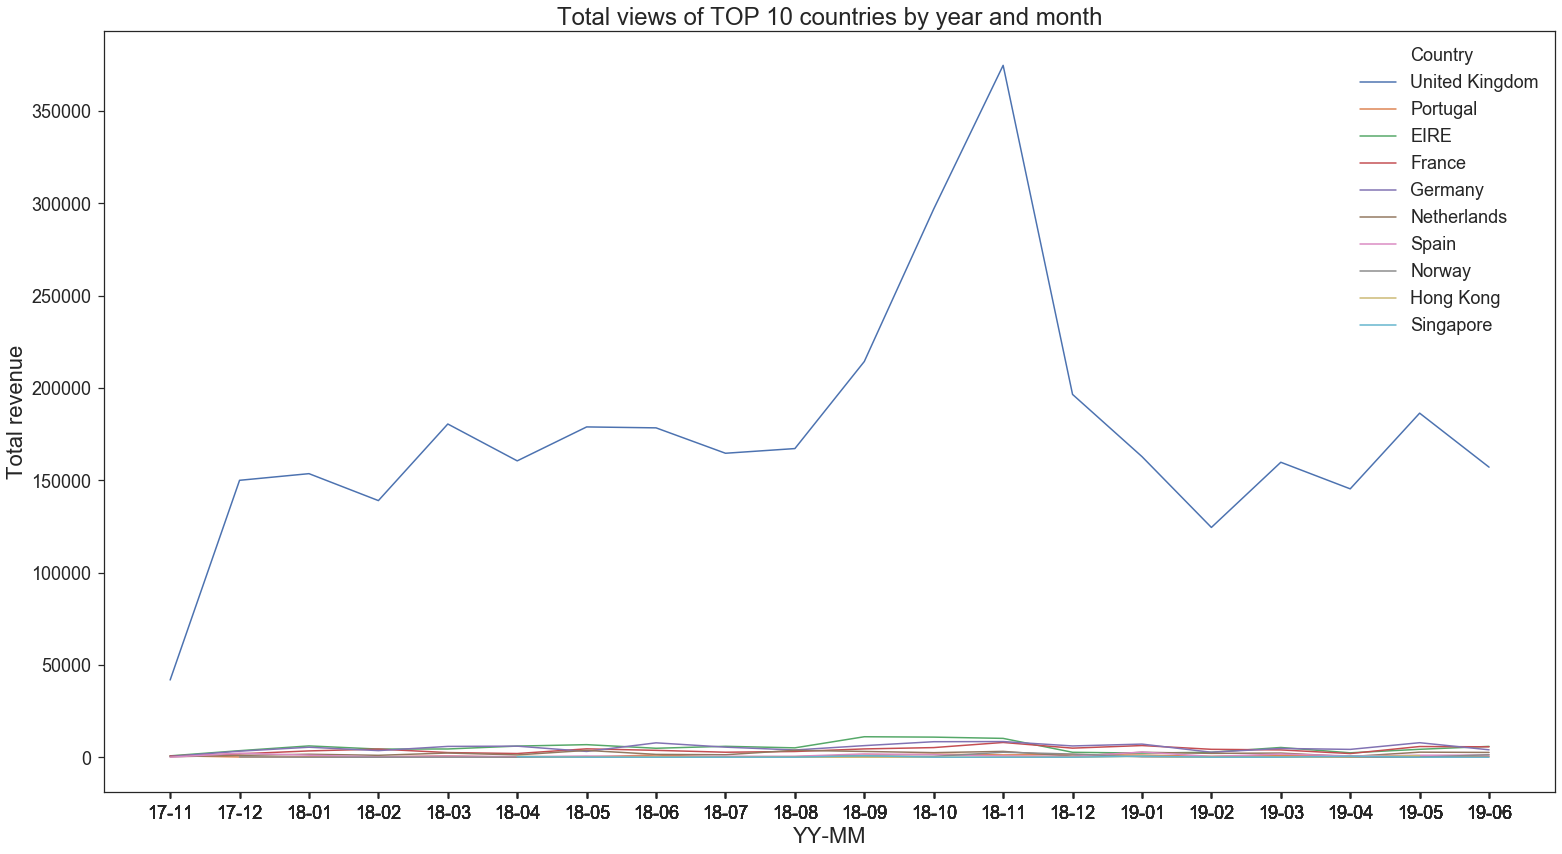

In [41]:
plt.figure(figsize=(26,14))

ax1 = sns.lineplot(x='year_month_sh', y='Total views', hue='Country',             
             data=df_yymm_tv).set_title("Total views of TOP 10 countries by year and month",fontsize=24)
        
plt.xticks(df_yymm_tv.year_month_sh, fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('YY-MM',fontsize=22)
plt.ylabel('Total revenue',fontsize=22)
plt.legend(loc='upper right',fontsize=18)

#### Insight:
    Total views trend seems quite flat for all countries compare to United Kingdom.    

### 5.10 Total views by year and month for each TOP 10 countries

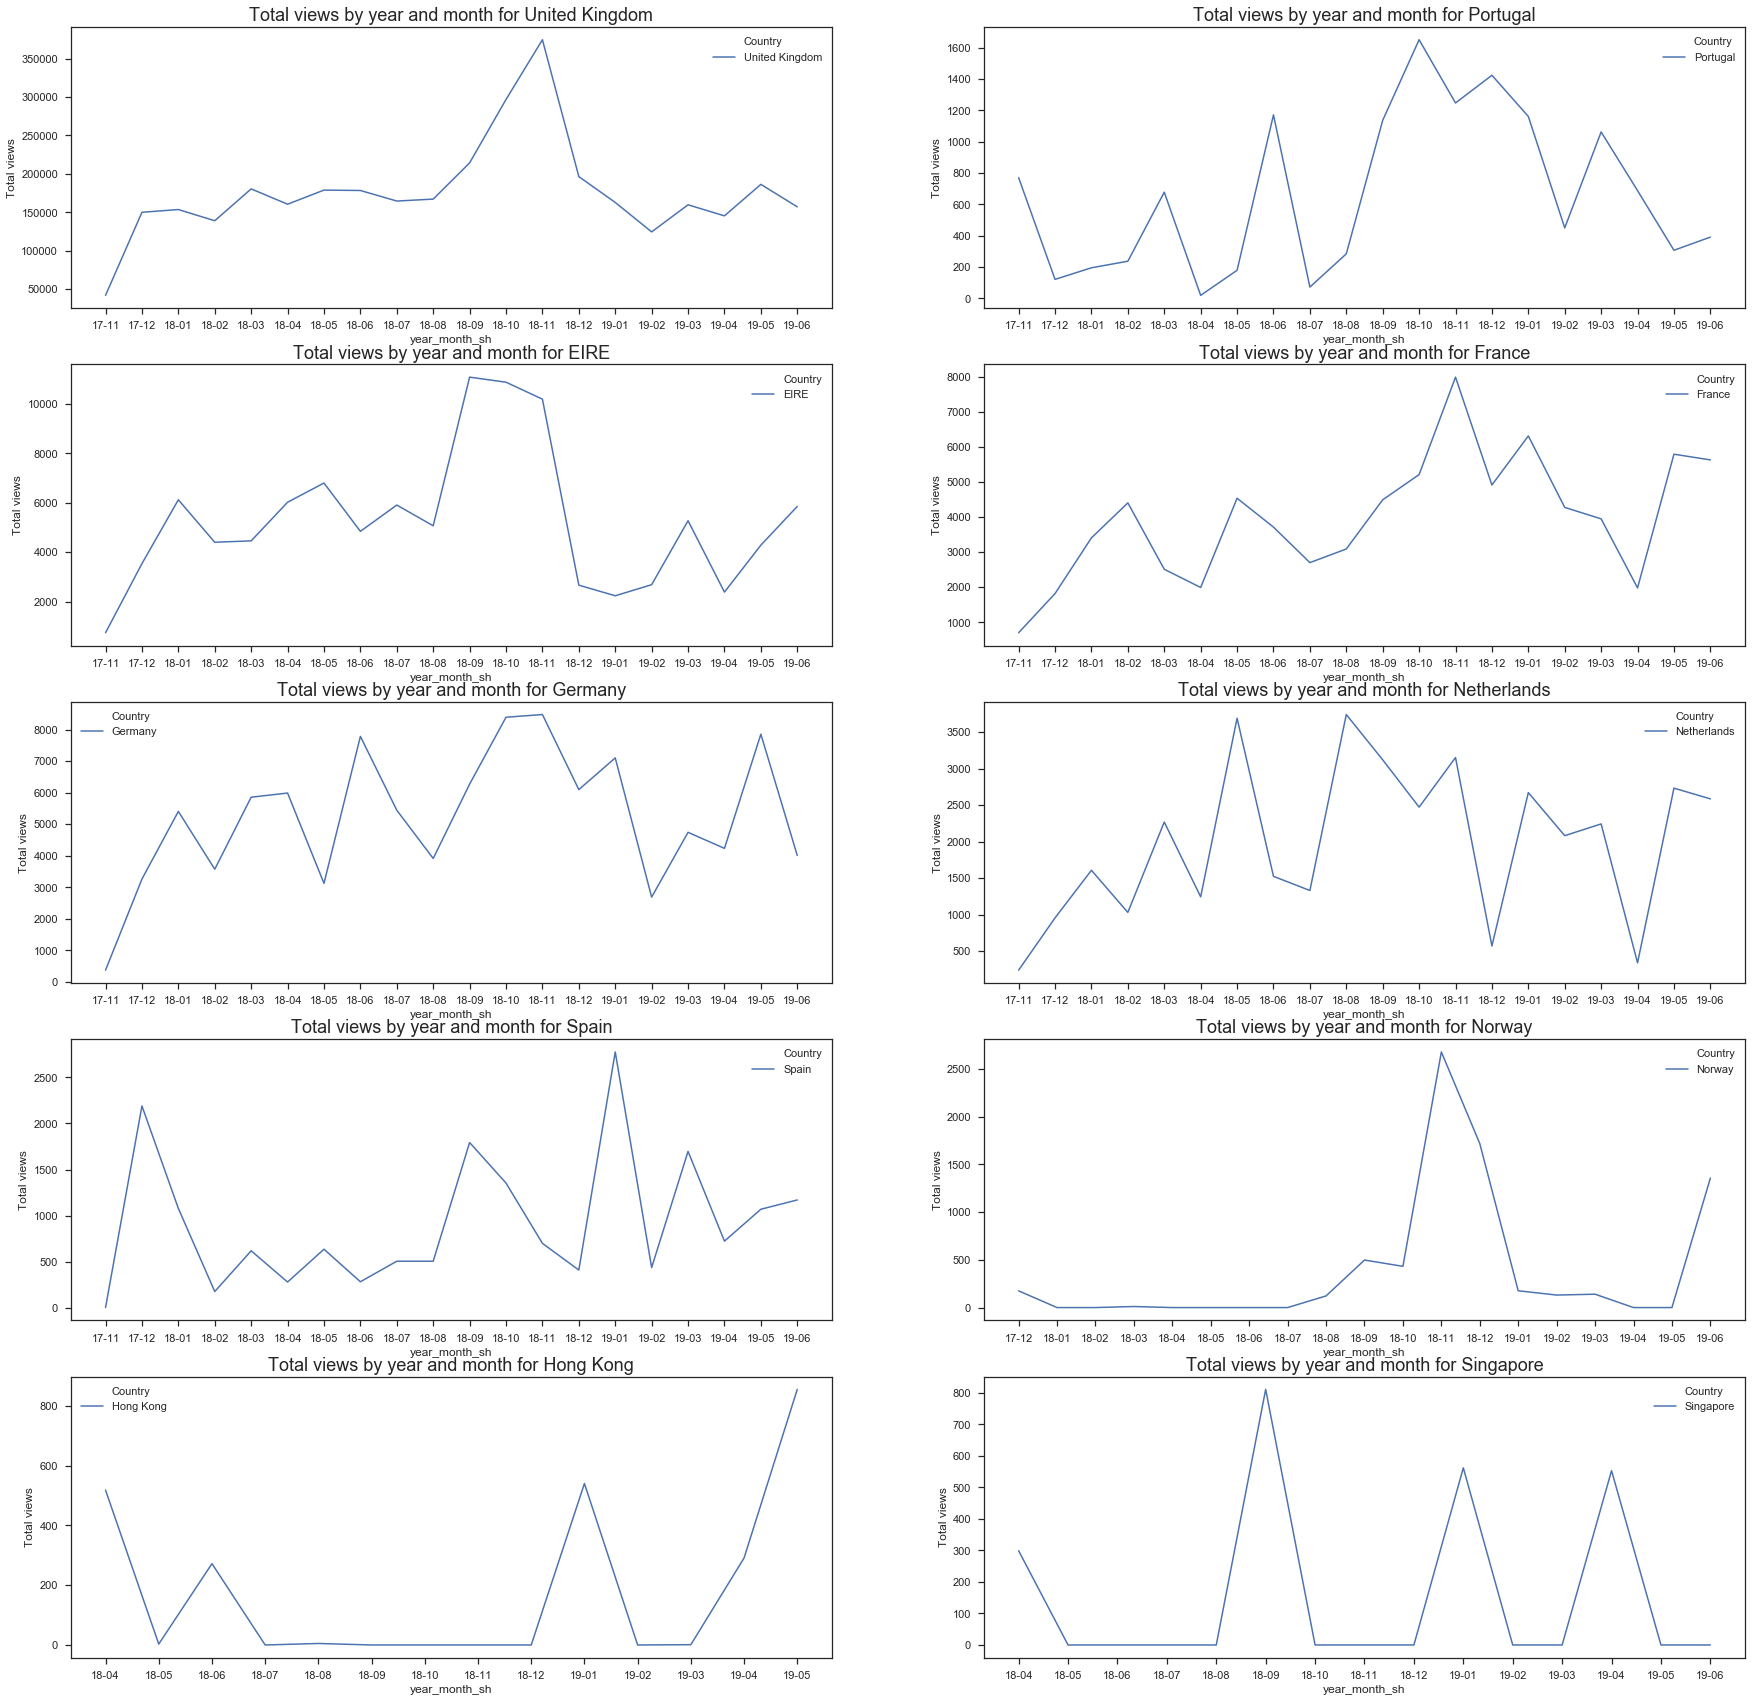

In [42]:
fig = plt.figure(figsize=(30,30))

country_list = df_yymm_tv.Country.unique()

for i in range(1,11):
    ax = fig.add_subplot(5, 2, i)
    country_name = country_list[i-1]
    
    sns.lineplot(x='year_month_sh', y='Total views', hue='Country',             
             data=df_yymm_tv[df_yymm_tv.Country == country_name]).set_title("Total views by year and month for "+country_name,
                                                                     fontsize=18)

#### Insight:
    Time views trend is different for each country. 
    Volatile trend with high peaks are typical for most of the countries.

### 6. Stationarity check of a time-series on daily basis

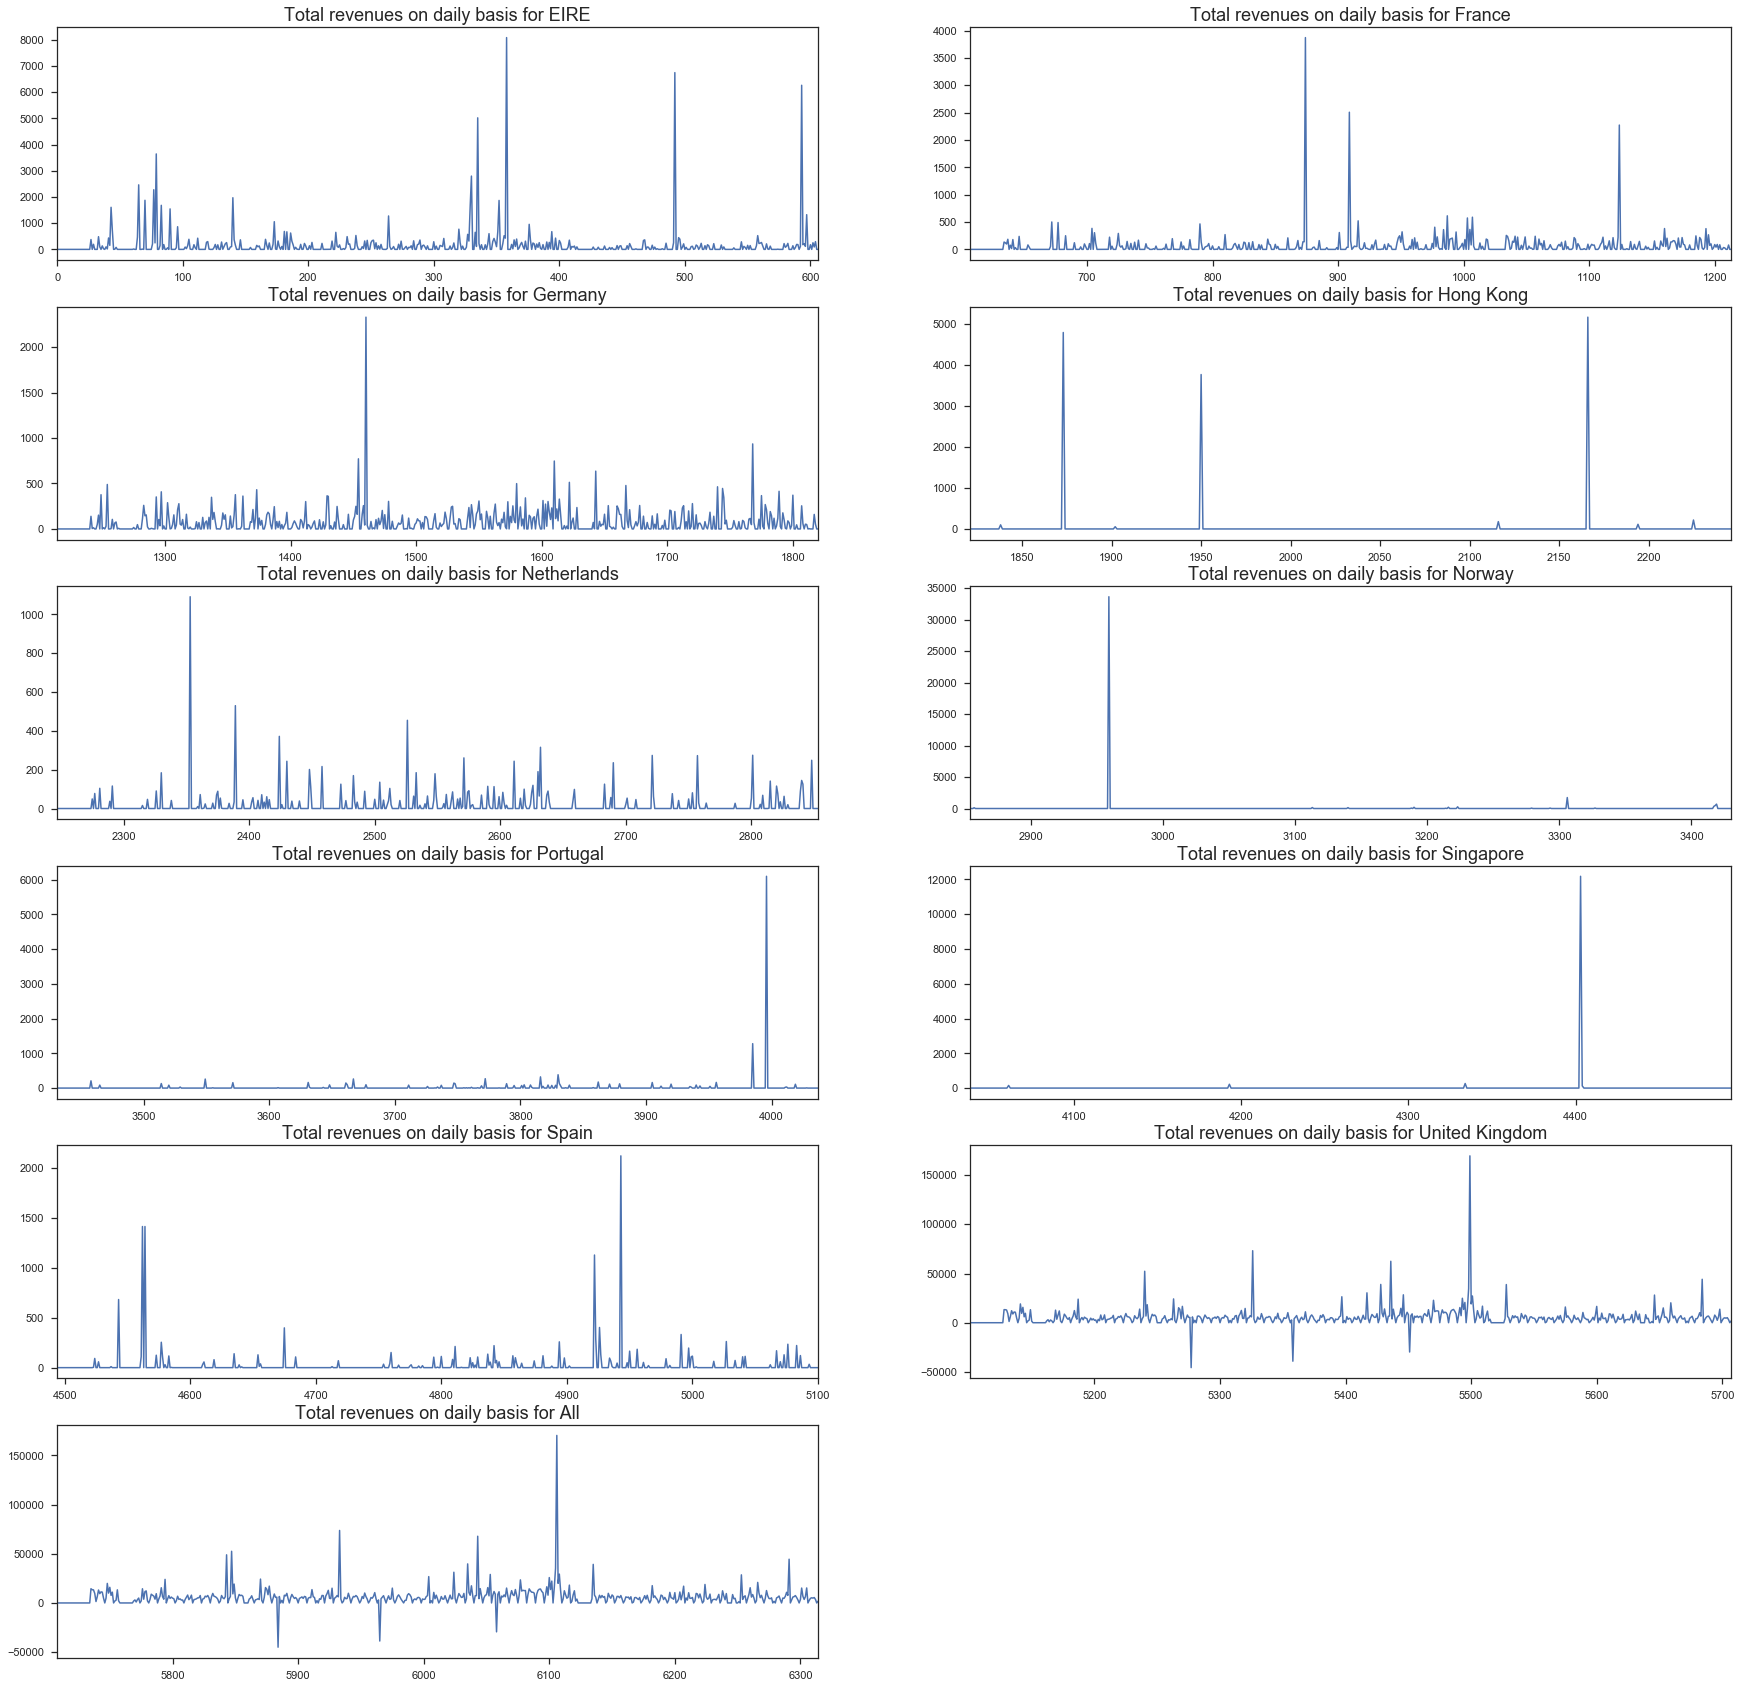

In [43]:
fig = plt.figure(figsize=(30,30))

country_list = df_ts_all.country.unique()

for i in range(1,12):
    ax = fig.add_subplot(6, 2, i)
    country_name = country_list[i-1]
    data=df_ts_all['revenue'][df_ts_all.country == country_name]
    
    data.plot()
    plt.title("Total revenues on daily basis for "+country_name, fontsize=18)

In [44]:
def test_stationarity(timeseries, country_name,col):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for '+country_name)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dfoutput[0] < dfoutput[4]:
        print('The test statistic value is even smaller than 1% of the critical value.\nConclusion: Timeseries data for '+col+' are stationary.') 
    else: 
        print('The test statistic value is higher than 1% of the critical value.\nConclusion: Timeseries data for '+col+' are not stationary.')

In [45]:
def stacionarity_check_for_countries(df,col):
    country_list = df.country.unique()
    
    for i in range(1,12):        
        country_name = country_list[i-1]
        print('')
        print('Country: '+country_name)
        data=df[col][df.country == country_name]

        test_stationarity(data,country_name,col)   


Country: EIRE


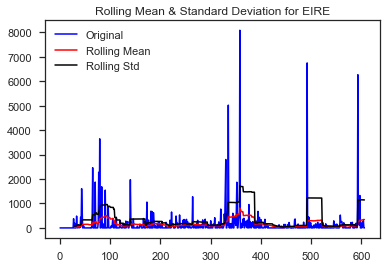

Results of Dickey-Fuller Test:
Test Statistic                 -23.724901
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: France


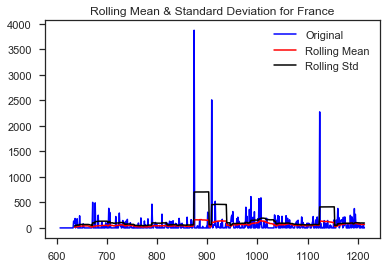

Results of Dickey-Fuller Test:
Test Statistic                 -24.079615
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: Germany


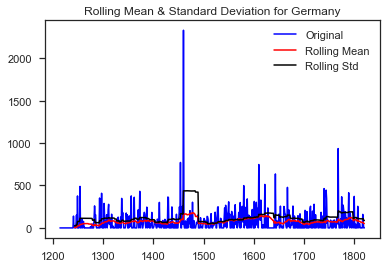

Results of Dickey-Fuller Test:
Test Statistic                -7.442334e+00
p-value                        5.960483e-11
#Lags Used                     6.000000e+00
Number of Observations Used    6.000000e+02
Critical Value (1%)           -3.441296e+00
Critical Value (5%)           -2.866369e+00
Critical Value (10%)          -2.569342e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: Hong Kong


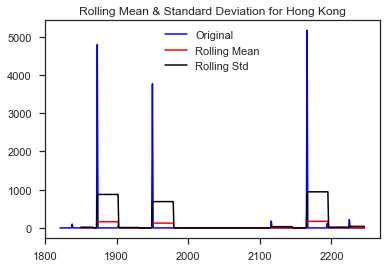

Results of Dickey-Fuller Test:
Test Statistic                 -20.725479
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    425.000000
Critical Value (1%)             -3.445831
Critical Value (5%)             -2.868365
Critical Value (10%)            -2.570405
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: Netherlands


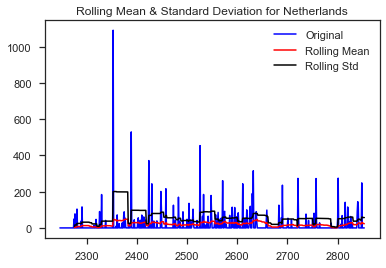

Results of Dickey-Fuller Test:
Test Statistic                 -24.645798
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: Norway


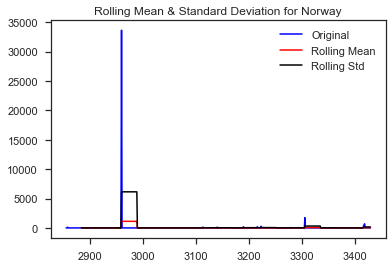

Results of Dickey-Fuller Test:
Test Statistic                 -24.001797
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    576.000000
Critical Value (1%)             -3.441754
Critical Value (5%)             -2.866571
Critical Value (10%)            -2.569449
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: Portugal


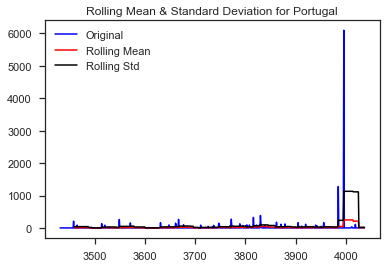

Results of Dickey-Fuller Test:
Test Statistic                -6.179906e+00
p-value                        6.493129e-08
#Lags Used                     1.000000e+01
Number of Observations Used    5.960000e+02
Critical Value (1%)           -3.441370e+00
Critical Value (5%)           -2.866402e+00
Critical Value (10%)          -2.569359e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: Singapore


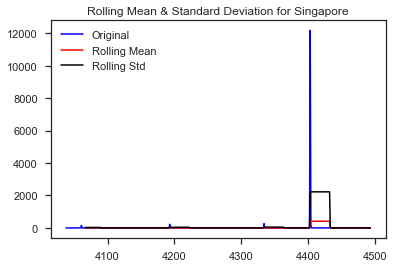

Results of Dickey-Fuller Test:
Test Statistic                 -21.113543
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    455.000000
Critical Value (1%)             -3.444804
Critical Value (5%)             -2.867913
Critical Value (10%)            -2.570165
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: Spain


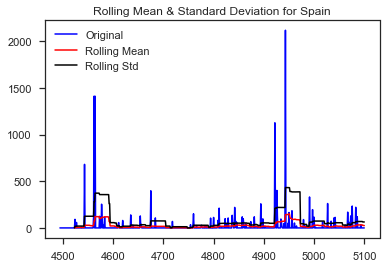

Results of Dickey-Fuller Test:
Test Statistic                -1.474282e+01
p-value                        2.555067e-27
#Lags Used                     1.000000e+00
Number of Observations Used    6.050000e+02
Critical Value (1%)           -3.441205e+00
Critical Value (5%)           -2.866329e+00
Critical Value (10%)          -2.569320e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: United Kingdom


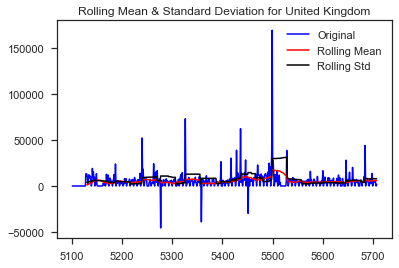

Results of Dickey-Fuller Test:
Test Statistic                -6.371779e+00
p-value                        2.335462e-08
#Lags Used                     7.000000e+00
Number of Observations Used    5.990000e+02
Critical Value (1%)           -3.441314e+00
Critical Value (5%)           -2.866377e+00
Critical Value (10%)          -2.569346e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.

Country: All


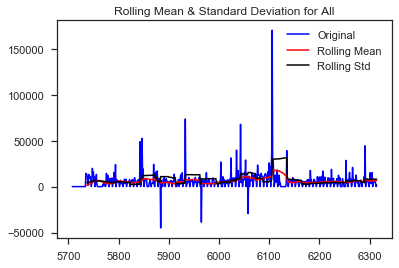

Results of Dickey-Fuller Test:
Test Statistic                -6.951704e+00
p-value                        9.655360e-10
#Lags Used                     6.000000e+00
Number of Observations Used    6.000000e+02
Critical Value (1%)           -3.441296e+00
Critical Value (5%)           -2.866369e+00
Critical Value (10%)          -2.569342e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for revenue are stationary.


In [46]:
stacionarity_check_for_countries(df=df_ts_all,col='revenue')


Country: EIRE


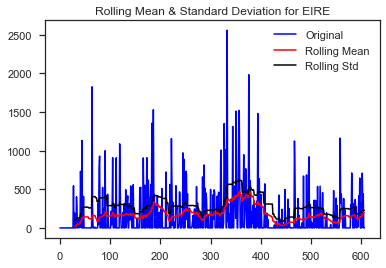

Results of Dickey-Fuller Test:
Test Statistic                -6.566859e+00
p-value                        8.118224e-09
#Lags Used                     6.000000e+00
Number of Observations Used    6.000000e+02
Critical Value (1%)           -3.441296e+00
Critical Value (5%)           -2.866369e+00
Critical Value (10%)          -2.569342e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: France


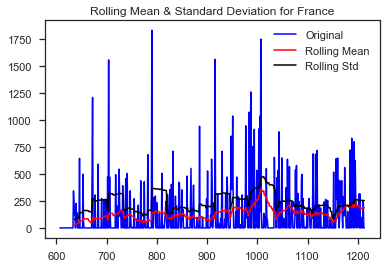

Results of Dickey-Fuller Test:
Test Statistic                -1.564526e+01
p-value                        1.621511e-28
#Lags Used                     1.000000e+00
Number of Observations Used    6.050000e+02
Critical Value (1%)           -3.441205e+00
Critical Value (5%)           -2.866329e+00
Critical Value (10%)          -2.569320e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: Germany


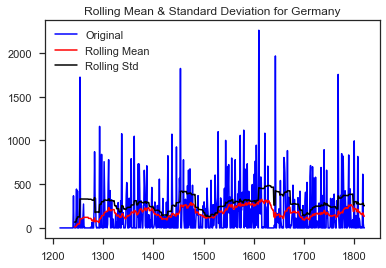

Results of Dickey-Fuller Test:
Test Statistic                -5.654456e+00
p-value                        9.692510e-07
#Lags Used                     1.300000e+01
Number of Observations Used    5.930000e+02
Critical Value (1%)           -3.441426e+00
Critical Value (5%)           -2.866426e+00
Critical Value (10%)          -2.569372e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: Hong Kong


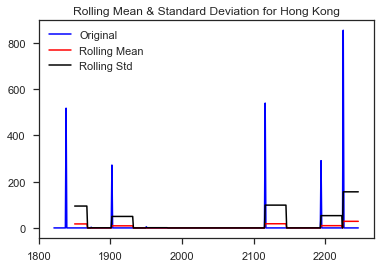

Results of Dickey-Fuller Test:
Test Statistic                 -20.776260
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    425.000000
Critical Value (1%)             -3.445831
Critical Value (5%)             -2.868365
Critical Value (10%)            -2.570405
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: Netherlands


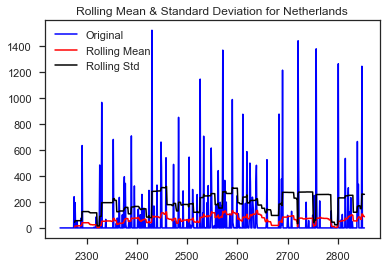

Results of Dickey-Fuller Test:
Test Statistic                -1.563694e+01
p-value                        1.658482e-28
#Lags Used                     2.000000e+00
Number of Observations Used    6.040000e+02
Critical Value (1%)           -3.441223e+00
Critical Value (5%)           -2.866337e+00
Critical Value (10%)          -2.569325e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: Norway


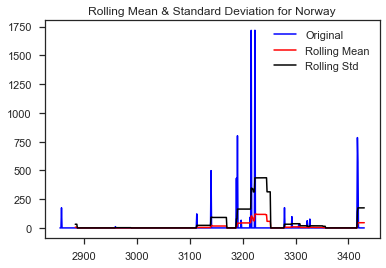

Results of Dickey-Fuller Test:
Test Statistic                -6.421722e+00
p-value                        1.784726e-08
#Lags Used                     1.300000e+01
Number of Observations Used    5.630000e+02
Critical Value (1%)           -3.442019e+00
Critical Value (5%)           -2.866687e+00
Critical Value (10%)          -2.569511e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: Portugal


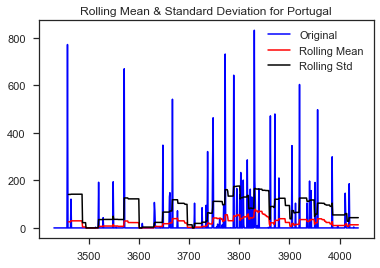

Results of Dickey-Fuller Test:
Test Statistic                 -24.248060
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: Singapore


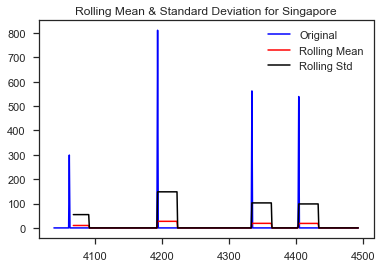

Results of Dickey-Fuller Test:
Test Statistic                 -21.336715
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    455.000000
Critical Value (1%)             -3.444804
Critical Value (5%)             -2.867913
Critical Value (10%)            -2.570165
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: Spain


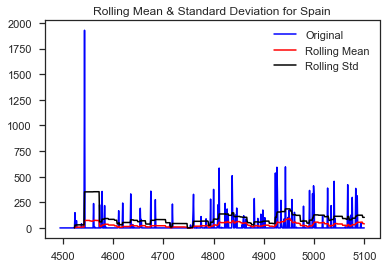

Results of Dickey-Fuller Test:
Test Statistic                 -24.648335
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: United Kingdom


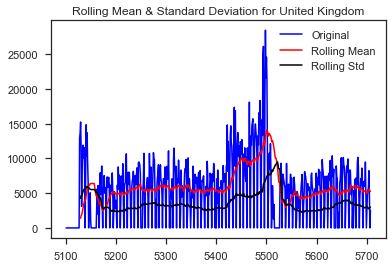

Results of Dickey-Fuller Test:
Test Statistic                  -4.960550
p-value                          0.000027
#Lags Used                      16.000000
Number of Observations Used    590.000000
Critical Value (1%)             -3.441482
Critical Value (5%)             -2.866451
Critical Value (10%)            -2.569386
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.

Country: All


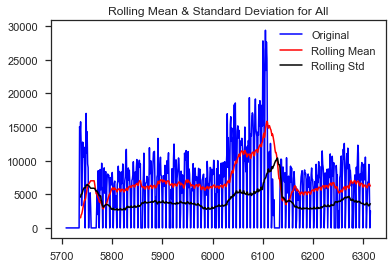

Results of Dickey-Fuller Test:
Test Statistic                  -4.751477
p-value                          0.000067
#Lags Used                      16.000000
Number of Observations Used    590.000000
Critical Value (1%)             -3.441482
Critical Value (5%)             -2.866451
Critical Value (10%)            -2.569386
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for total_views are stationary.


In [47]:
stacionarity_check_for_countries(df=df_ts_all,col='total_views')


Country: EIRE


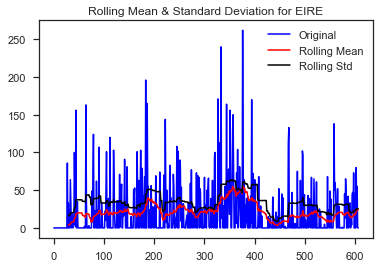

Results of Dickey-Fuller Test:
Test Statistic                  -4.766190
p-value                          0.000063
#Lags Used                      13.000000
Number of Observations Used    593.000000
Critical Value (1%)             -3.441426
Critical Value (5%)             -2.866426
Critical Value (10%)            -2.569372
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: France


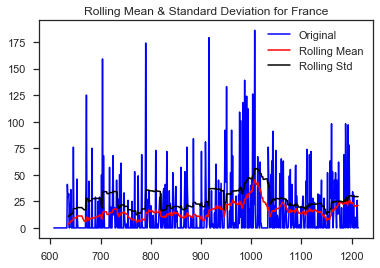

Results of Dickey-Fuller Test:
Test Statistic                -1.495425e+01
p-value                        1.267009e-27
#Lags Used                     1.000000e+00
Number of Observations Used    6.050000e+02
Critical Value (1%)           -3.441205e+00
Critical Value (5%)           -2.866329e+00
Critical Value (10%)          -2.569320e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: Germany


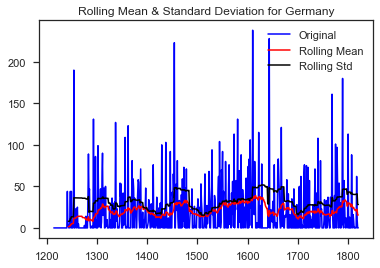

Results of Dickey-Fuller Test:
Test Statistic                  -5.629992
p-value                          0.000001
#Lags Used                      13.000000
Number of Observations Used    593.000000
Critical Value (1%)             -3.441426
Critical Value (5%)             -2.866426
Critical Value (10%)            -2.569372
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: Hong Kong


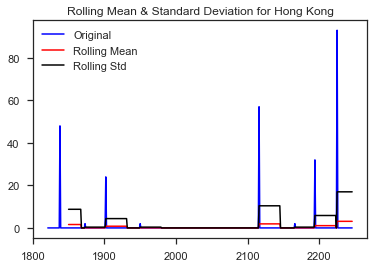

Results of Dickey-Fuller Test:
Test Statistic                 -20.777003
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    425.000000
Critical Value (1%)             -3.445831
Critical Value (5%)             -2.868365
Critical Value (10%)            -2.570405
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: Netherlands


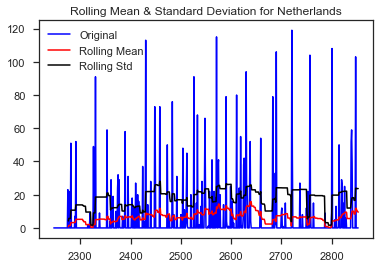

Results of Dickey-Fuller Test:
Test Statistic                -1.545059e+01
p-value                        2.787566e-28
#Lags Used                     2.000000e+00
Number of Observations Used    6.040000e+02
Critical Value (1%)           -3.441223e+00
Critical Value (5%)           -2.866337e+00
Critical Value (10%)          -2.569325e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: Norway


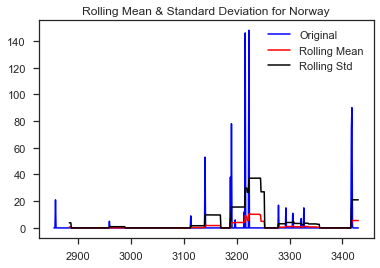

Results of Dickey-Fuller Test:
Test Statistic                -6.724038e+00
p-value                        3.425444e-09
#Lags Used                     7.000000e+00
Number of Observations Used    5.690000e+02
Critical Value (1%)           -3.441895e+00
Critical Value (5%)           -2.866633e+00
Critical Value (10%)          -2.569482e+00
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: Portugal


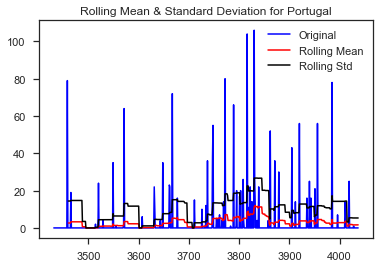

Results of Dickey-Fuller Test:
Test Statistic                 -24.138120
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: Singapore


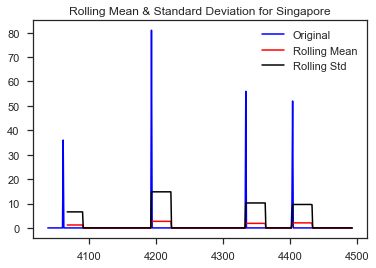

Results of Dickey-Fuller Test:
Test Statistic                 -20.672186
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    455.000000
Critical Value (1%)             -3.444804
Critical Value (5%)             -2.867913
Critical Value (10%)            -2.570165
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: Spain


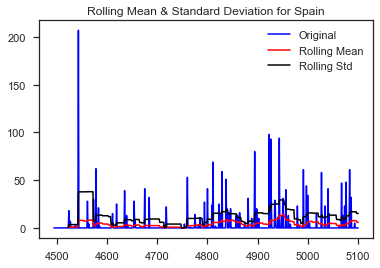

Results of Dickey-Fuller Test:
Test Statistic                 -24.973585
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: United Kingdom


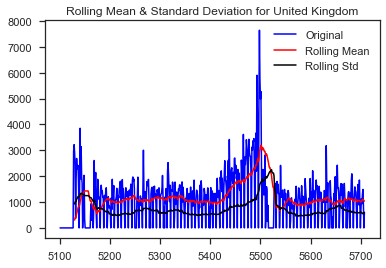

Results of Dickey-Fuller Test:
Test Statistic                  -4.855796
p-value                          0.000042
#Lags Used                      16.000000
Number of Observations Used    590.000000
Critical Value (1%)             -3.441482
Critical Value (5%)             -2.866451
Critical Value (10%)            -2.569386
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.

Country: All


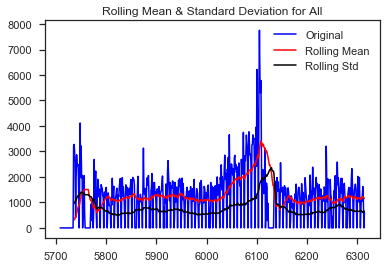

Results of Dickey-Fuller Test:
Test Statistic                  -4.753035
p-value                          0.000067
#Lags Used                      16.000000
Number of Observations Used    590.000000
Critical Value (1%)             -3.441482
Critical Value (5%)             -2.866451
Critical Value (10%)            -2.569386
dtype: float64
The test statistic value is even smaller than 1% of the critical value.
Conclusion: Timeseries data for purchases are stationary.


In [48]:
stacionarity_check_for_countries(df=df_ts_all,col='purchases')

#### Insight:
    Time series data for revenue, total_view and purchases are stationary for each TOP 10 countries adn also for dataset related to All data.   

### 7. Hypothesis Testing

We could use an ANOVA approach to check if there is a significant difference between countries.

In [49]:
N = np.unique(df_ts_all['country'][df_ts_all.country != 'All'].values).size
print("num comparisons: ",((N-1)*N) / 2.0)

num comparisons:  45.0


In [50]:
def calc_mean_and_anova(df, col):
    UK = df[col][df.country == 'United Kingdom']
    EI = df[col][df.country == 'EIRE']
    GE = df[col][df.country == 'Germany']
    FR = df[col][df.country == 'France']
    NR = df[col][df.country == 'Norway']
    SP = df[col][df.country == 'Spain']
    HK = df[col][df.country == 'Hong Kong']
    PT = df[col][df.country == 'Portugal']
    SG = df[col][df.country == 'Singapore']
    NE = df[col][df.country == 'Netherlands']
    
    all_countries = [UK, EI, GE, FR, NR, SP, HK, PT, SG, NE]
    
    global_mean = np.hstack(all_countries).mean()

    print('The global mean of '+col+' is: %s'%np.round(global_mean, decimals=2))

    for name, country in zip(['United Kingdom', 'EIRE', 'Germany', 'France', 
                          'Norway', 'Spain', 'Hong Kong', 'Portugal', 
                          'Singapore', 'Netherlands'], all_countries):
        print("Mean "+col+" for {} is {}".format(name, np.round(country.mean(), decimals=2)))
        
    test_statistic, pvalue = stats.f_oneway(*all_countries)   
   
    return print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(test_statistic, pvalue))

In [51]:
calc_mean_and_anova(df_ts_all, col='revenue')

The global mean of revenue is: 637.61
Mean revenue for United Kingdom is 5508.32
Mean revenue for EIRE is 172.31
Mean revenue for Germany is 75.21
Mean revenue for France is 64.23
Mean revenue for Norway is 66.42
Mean revenue for Spain is 25.36
Mean revenue for Hong Kong is 33.79
Mean revenue for Portugal is 21.96
Mean revenue for Singapore is 28.39
Mean revenue for Netherlands is 20.26
F statistic = 162.965 and probability p = 0.000


In [52]:
calc_mean_and_anova(df_ts_all, col='total_views')

The global mean of total_views is: 684.12
Mean total_views for United Kingdom is 5819.05
Mean total_views for EIRE is 173.64
Mean total_views for Germany is 172.31
Mean total_views for France is 130.78
Mean total_views for Norway is 12.89
Mean total_views for Spain is 30.3
Mean total_views for Hong Kong is 5.83
Mean total_views for Portugal is 21.83
Mean total_views for Singapore is 4.88
Mean total_views for Netherlands is 65.25
F statistic = 928.400 and probability p = 0.000


In [53]:
calc_mean_and_anova(df_ts_all, col='purchases')

The global mean of purchases is: 132.68
Mean purchases for United Kingdom is 1174.85
Mean purchases for EIRE is 21.28
Mean purchases for Germany is 20.44
Mean purchases for France is 15.58
Mean purchases for Norway is 1.29
Mean purchases for Spain is 4.0
Mean purchases for Hong Kong is 0.61
Mean purchases for Portugal is 2.84
Mean purchases for Singapore is 0.52
Mean purchases for Netherlands is 6.61
F statistic = 841.289 and probability p = 0.000


#### Insight:

    As p < a (0.05) we state that we have a main interaction effect. This simply means that amongst group comparison identifies statistically significant differences for revenue, total view and purchases.
    However, this result does not identify the sample pair (or pairs) which cause this significance.